In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 36.5 MB/s eta 0:00:00


In [ ]:

import numpy as np
import cv2
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
import pywt

# CNN-based feature extractor using pretrained ResNet50
def extract_cnn_features(image, model, device):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = model(image_tensor)
    return features.cpu().numpy().flatten()

# Radiomic features using GLCM
def extract_glcm_features(image, distances=[1], angles=[0], levels=256):
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    return [contrast, homogeneity, energy, correlation]

# Radiomic features using Local Binary Pattern (LBP)
def extract_lbp_features(image, P=8, R=1):
    lbp = local_binary_pattern(image, P, R, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist.tolist()

# Radiomic features using Wavelet decomposition
def extract_wavelet_features(image):
    coeffs2 = pywt.dwt2(image, 'haar')
    cA, (cH, cV, cD) = coeffs2
    features = [np.mean(cA), np.std(cA), np.mean(cH), np.std(cH), np.mean(cV), np.std(cV), np.mean(cD), np.std(cD)]
    return features

# Master feature engineering function
def extract_all_features(image, cnn_model, device):
    if len(image.shape) == 3:
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        image_gray = image

    cnn_features = extract_cnn_features(image, cnn_model, device)
    glcm_features = extract_glcm_features(image_gray)
    lbp_features = extract_lbp_features(image_gray)
    wavelet_features = extract_wavelet_features(image_gray)

    all_features = np.concatenate([cnn_features, glcm_features, lbp_features, wavelet_features])
    return all_features


In [ ]:
!pip install PyWavelets

In [ ]:
import numpy as np
import cv2
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
import pywt
import pandas as pd
import pydicom

# 1️⃣ CNN-based feature extractor using pretrained ResNet50
def extract_cnn_features(image, model, device):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # Convert single channel to 3
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = model(image_tensor)
    return features.cpu().numpy().flatten()

# 2️⃣ Radiomic features using GLCM
def extract_glcm_features(image, distances=[1], angles=[0], levels=256):
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    return [contrast, homogeneity, energy, correlation]

# 3️⃣ Radiomic features using Local Binary Pattern (LBP)
def extract_lbp_features(image, P=8, R=1):
    lbp = local_binary_pattern(image, P, R, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist.tolist()

# 4️⃣ Radiomic features using Wavelet decomposition
def extract_wavelet_features(image):
    coeffs2 = pywt.dwt2(image, 'haar')
    cA, (cH, cV, cD) = coeffs2
    features = [
        np.mean(cA), np.std(cA),
        np.mean(cH), np.std(cH),
        np.mean(cV), np.std(cV),
        np.mean(cD), np.std(cD)
    ]
    return features

# 5️⃣ Master feature engineering function
def extract_all_features(image, cnn_model, device):
    image_uint8 = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

    cnn_features = extract_cnn_features(image_uint8, cnn_model, device)
    glcm_features = extract_glcm_features(image_uint8)
    lbp_features = extract_lbp_features(image_uint8)
    wavelet_features = extract_wavelet_features(image_uint8)

    all_features = np.concatenate([cnn_features, glcm_features, lbp_features, wavelet_features])
    return all_features

# 6️⃣ Load DICOM image and model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn_model = models.resnet50(pretrained=True)
cnn_model.fc = torch.nn.Identity()
cnn_model = cnn_model.to(device)
cnn_model.eval()

# Load your DICOM image here
dicom_path = '/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Fabrosis/P278/SER00003/I00071'
dicom_data = pydicom.dcmread(dicom_path)
image = dicom_data.pixel_array

# 7️⃣ Extract features
features = extract_all_features(image, cnn_model, device)

# 8️⃣ Convert to DataFrame for easy viewing
feature_names = [f'feature_{i+1}' for i in range(len(features))]
df_features = pd.DataFrame([features], columns=feature_names)

# 9️⃣ Print numerical features
print(df_features.T)
print(f"Total features extracted: {len(features)}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


                     0
feature_1     0.199781
feature_2     0.099518
feature_3     0.143511
feature_4     0.020418
feature_5     0.213322
...                ...
feature_2066  8.750974
feature_2067 -0.024376
feature_2068  7.345685
feature_2069 -0.000557
feature_2070  4.480576

[2070 rows x 1 columns]
Total features extracted: 2070


In [ ]:
import pydicom
import numpy as np
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
import pywt
from skimage import exposure

image_path = "/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Fabrosis/P278/SER00003/I00071"

dicom = pydicom.dcmread(image_path)
image = dicom.pixel_array

image_norm = exposure.rescale_intensity(image, out_range=(0, 255)).astype(np.uint8)

def extract_glcm_features(image, distances=[1], angles=[0], levels=256):
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    return [contrast, homogeneity, energy, correlation]

def extract_lbp_features(image, P=8, R=1):
    lbp = local_binary_pattern(image, P, R, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist.tolist()

def extract_wavelet_features(image):
    coeffs2 = pywt.dwt2(image, 'haar')
    cA, (cH, cV, cD) = coeffs2
    features = [
        np.mean(cA), np.std(cA),
        np.mean(cH), np.std(cH),
        np.mean(cV), np.std(cV),
        np.mean(cD), np.std(cD)
    ]
    return features

glcm_features = extract_glcm_features(image_norm)
lbp_features = extract_lbp_features(image_norm)
wavelet_features = extract_wavelet_features(image_norm)

all_features = glcm_features + lbp_features + wavelet_features

for f in all_features:
    print(f)


71.40636084271037
0.5523208672267919
0.24953689409087804
0.990170693696489
0.06373596191381936
0.0854759216305333
0.023277282714754953
0.03861999511704017
0.05500030517557144
0.04691314697247729
0.03901672363266366
0.08147048950164233
0.39471054076997864
0.1717796325677041
200.4979476928711
120.11244324815075
-0.0021438598632812778
8.744666036736362
-0.02877044677734372
7.328175497188465
-0.004539489746093771
4.46642818203637


In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 25.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive

try:
    drive.mount('/content/drive')
except ValueError:
    print("Drive already mounted. Skipping mount.")

Mounted at /content/drive


In [ ]:
import pydicom
import numpy as np
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
import pywt
from skimage import exposure

image_path = "/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Fabrosis/P278/SER00003/I00071"

dicom = pydicom.dcmread(image_path)
image = dicom.pixel_array

image_norm = exposure.rescale_intensity(image, out_range=(0, 255)).astype(np.uint8)

def extract_glcm_features(image, distances=[1], angles=[0], levels=256):
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    return [contrast, homogeneity, energy, correlation]

def extract_lbp_features(image, P=8, R=1):
    lbp = local_binary_pattern(image, P, R, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist.tolist()

def extract_wavelet_features(image):
    coeffs2 = pywt.dwt2(image, 'haar')
    cA, (cH, cV, cD) = coeffs2
    features = [
        np.mean(cA), np.std(cA),
        np.mean(cH), np.std(cH),
        np.mean(cV), np.std(cV),
        np.mean(cD), np.std(cD)
    ]
    return features

glcm_features = extract_glcm_features(image_norm)
lbp_features = extract_lbp_features(image_norm)
wavelet_features = extract_wavelet_features(image_norm)

print("🔸 GLCM Features:")
glcm_names = ['Contrast', 'Homogeneity', 'Energy', 'Correlation']
for name, value in zip(glcm_names, glcm_features):
    print(f"{name}: {value}")

print("\n🔸 LBP Histogram Bins:")
for i, value in enumerate(lbp_features):
    print(f"LBP Bin {i}: {value}")

print("\n🔸 Wavelet Features:")
wavelet_names = ['cA Mean', 'cA Std', 'cH Mean', 'cH Std', 'cV Mean', 'cV Std', 'cD Mean', 'cD Std']
for name, value in zip(wavelet_names, wavelet_features):
    print(f"{name}: {value}")


🔸 GLCM Features:
Contrast: 71.40636084271037
Homogeneity: 0.5523208672267919
Energy: 0.24953689409087804
Correlation: 0.990170693696489

🔸 LBP Histogram Bins:
LBP Bin 0: 0.06373596191381936
LBP Bin 1: 0.0854759216305333
LBP Bin 2: 0.023277282714754953
LBP Bin 3: 0.03861999511704017
LBP Bin 4: 0.05500030517557144
LBP Bin 5: 0.04691314697247729
LBP Bin 6: 0.03901672363266366
LBP Bin 7: 0.08147048950164233
LBP Bin 8: 0.39471054076997864
LBP Bin 9: 0.1717796325677041

🔸 Wavelet Features:
cA Mean: 200.4979476928711
cA Std: 120.11244324815075
cH Mean: -0.0021438598632812778
cH Std: 8.744666036736362
cV Mean: -0.02877044677734372
cV Std: 7.328175497188465
cD Mean: -0.004539489746093771
cD Std: 4.46642818203637


In [ ]:
import os
import pydicom
import numpy as np
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
import pywt
from skimage import exposure
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Paths
dataset_path = "/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Normal/P253/Series4/0768.dcm"

# Feature extraction functions
def extract_glcm_features(image, distances=[1], angles=[0], levels=256):
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    return [contrast, homogeneity, energy, correlation]

def extract_lbp_features(image, P=8, R=1):
    lbp = local_binary_pattern(image, P, R, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist.tolist()

def extract_wavelet_features(image):
    coeffs2 = pywt.dwt2(image, 'haar')
    cA, (cH, cV, cD) = coeffs2
    features = [
        np.mean(cA), np.std(cA),
        np.mean(cH), np.std(cH),
        np.mean(cV), np.std(cV),
        np.mean(cD), np.std(cD)
    ]
    return features

# Initialize feature and label lists
X = []
y = []
import os
import pydicom
import numpy as np
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
import pywt
from skimage import exposure
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Paths
dataset_path = "/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Normal/P253/Series4/0768.dcm"

# Feature extraction functions
def extract_glcm_features(image, distances=[1], angles=[0], levels=256):
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    return [contrast, homogeneity, energy, correlation]

def extract_lbp_features(image, P=8, R=1):
    lbp = local_binary_pattern(image, P, R, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist.tolist()

def extract_wavelet_features(image):
    coeffs2 = pywt.dwt2(image, 'haar')
    cA, (cH, cV, cD) = coeffs2
    features = [
        np.mean(cA), np.std(cA),
        np.mean(cH), np.std(cH),
        np.mean(cV), np.std(cV),
        np.mean(cD), np.std(cD)
    ]
    return features

# Initialize feature and label lists
X = []
y = []

# Load class labels (filtering out non-directories like .DS_Store or files)
labels = [label for label in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, label))]
labels.sort()  # Keep order consistent

# Read images, extract features
for label in labels:
    label_path = os.path.join(dataset_path, label)
    for root, dirs, files in os.walk(label_path):
        for file in files:
            if file.lower().endswith('.dcm'):
                file_path = os.path.join(root, file)
                try:
                    dicom = pydicom.dcmread(file_path)
                    image = dicom.pixel_array

                    # Normalize image to 0-255 range
                    image_norm = exposure.rescale_intensity(image, out_range=(0, 255)).astype(np.uint8)

                    # Extract features
                    glcm_features = extract_glcm_features(image_norm)
                    lbp_features = extract_lbp_features(image_norm)
                    wavelet_features = extract_wavelet_features(image_norm)

                    # Combine features
                    features = glcm_features + lbp_features + wavelet_features
                    X.append(features)
                    y.append(label)
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")


# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=labels))
for label in labels:
    label_path = os.path.join(dataset_path, label)
    for root, dirs, files in os.walk(label_path):
        for file in files:
            if file.lower().endswith('.dcm'):
                file_path = os.path.join(root, file)
                dicom = pydicom.dcmread(file_path)
                image = dicom.pixel_array

                # Normalize image to 0-255 range
                image_norm = exposure.rescale_intensity(image, out_range=(0, 255)).astype(np.uint8)

                # Extract features
                glcm_features = extract_glcm_features(image_norm)
                lbp_features = extract_lbp_features(image_norm)
                wavelet_features = extract_wavelet_features(image_norm)

                # Combine features
                features = glcm_features + lbp_features + wavelet_features
                X.append(features)
                y.append(label)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=labels))


NotADirectoryError: [Errno 20] Not a directory: '/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Normal/P253/Series4/0768.dcm'

Found Labels: ['Fabrosis', 'Mild', 'Moderate', 'Normal', 'Severe']
Error reading /content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Fabrosis/P278/SER00003/I00002.dcm: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
Error reading /content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Normal/image8.dcm: The parameter `image` must be a 2-dimensional array
Error reading /content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Normal/image.dcm: The parameter `image` must be a 2-dimensional array
Error reading /content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Normal/P253/Series4/image888.dcm: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
Feature matrix shape: (30215, 22)
Labels shape: (30215,)


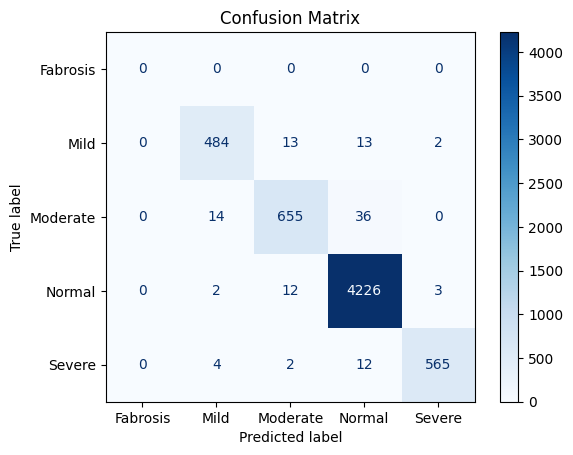


Classification Report:



ValueError: Number of classes, 4, does not match size of target_names, 5. Try specifying the labels parameter

In [ ]:
import os
import pydicom
import numpy as np
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
import pywt
from skimage import exposure
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ✅ Dataset path (parent folder containing class subfolders)
dataset_path = "/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/"

# ✅ GLCM feature extraction
def extract_glcm_features(image, distances=[1], angles=[0], levels=256):
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    return [contrast, homogeneity, energy, correlation]

# ✅ LBP feature extraction
def extract_lbp_features(image, P=8, R=1):
    lbp = local_binary_pattern(image, P, R, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist.tolist()

# ✅ Wavelet feature extraction
def extract_wavelet_features(image):
    coeffs2 = pywt.dwt2(image, 'haar')
    cA, (cH, cV, cD) = coeffs2
    features = [
        np.mean(cA), np.std(cA),
        np.mean(cH), np.std(cH),
        np.mean(cV), np.std(cV),
        np.mean(cD), np.std(cD)
    ]
    return features

# ✅ Initialize feature and label lists
X = []
y = []

# ✅ Load class labels (folder names inside dataset_path)
labels = [label for label in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, label))]
labels.sort()  # Keep order consistent
print("Found Labels:", labels)

# ✅ Read images, extract features
for label in labels:
    label_path = os.path.join(dataset_path, label)
    for root, dirs, files in os.walk(label_path):
        for file in files:
            if file.lower().endswith('.dcm'):
                file_path = os.path.join(root, file)
                try:
                    dicom = pydicom.dcmread(file_path)
                    image = dicom.pixel_array

                    # ✅ Normalize image to 0-255 range
                    image_norm = exposure.rescale_intensity(image, out_range=(0, 255)).astype(np.uint8)

                    # ✅ Extract features
                    glcm_features = extract_glcm_features(image_norm)
                    lbp_features = extract_lbp_features(image_norm)
                    wavelet_features = extract_wavelet_features(image_norm)

                    # ✅ Combine features
                    features = glcm_features + lbp_features + wavelet_features
                    X.append(features)
                    y.append(label)
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")

# ✅ Convert to numpy arrays
X = np.array(X)
y = np.array(y)

print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)

# ✅ Split dataset (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ✅ Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# ✅ Predictions
y_pred = clf.predict(X_test)

# ✅ Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# ✅ Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=labels))


In [ ]:
!pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 6.9 MB/s eta 0:00:00


Accuracy: 0.75
Precision (macro): 0.8
Recall (macro): 0.8
F1 Score (macro): 0.8
Accuracy: 0.75
Precision (macro): 0.8
Recall (macro): 0.8
F1 Score (macro): 0.8


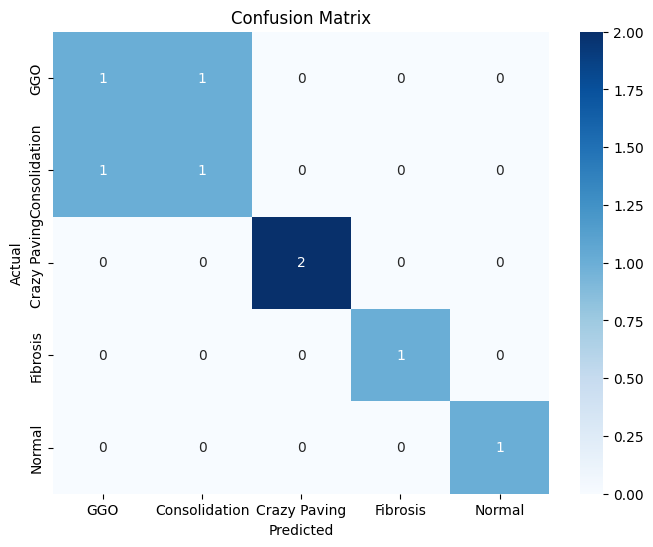

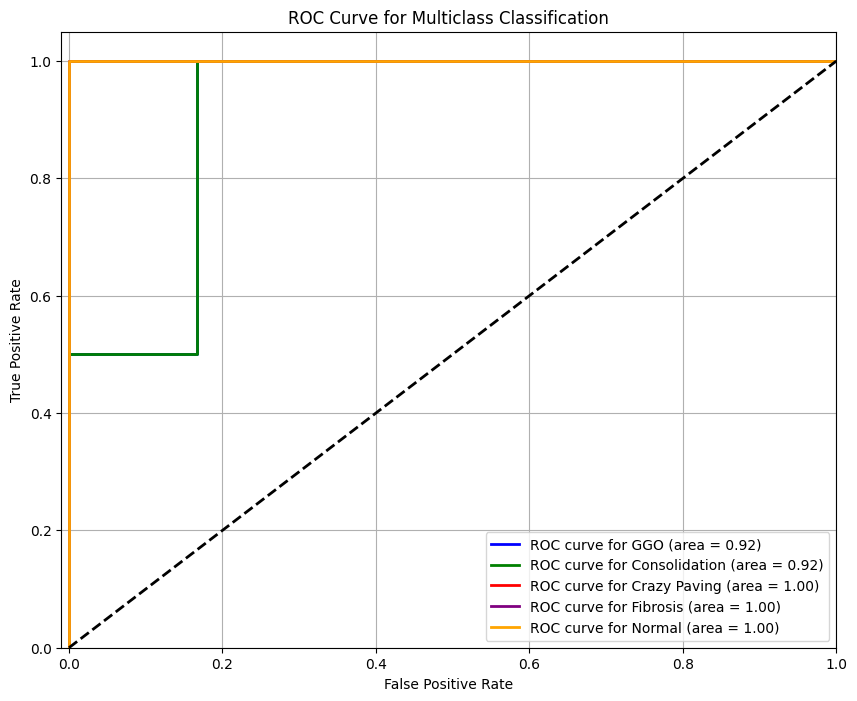

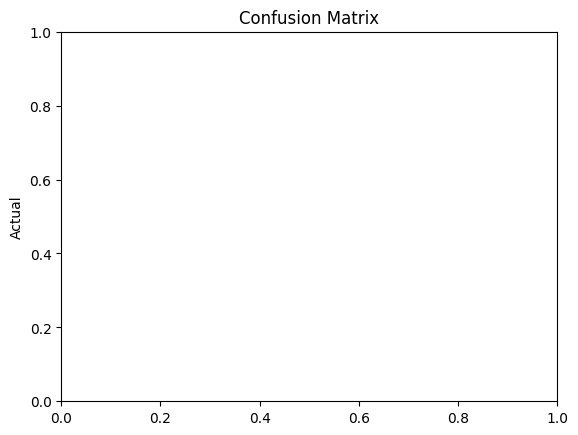

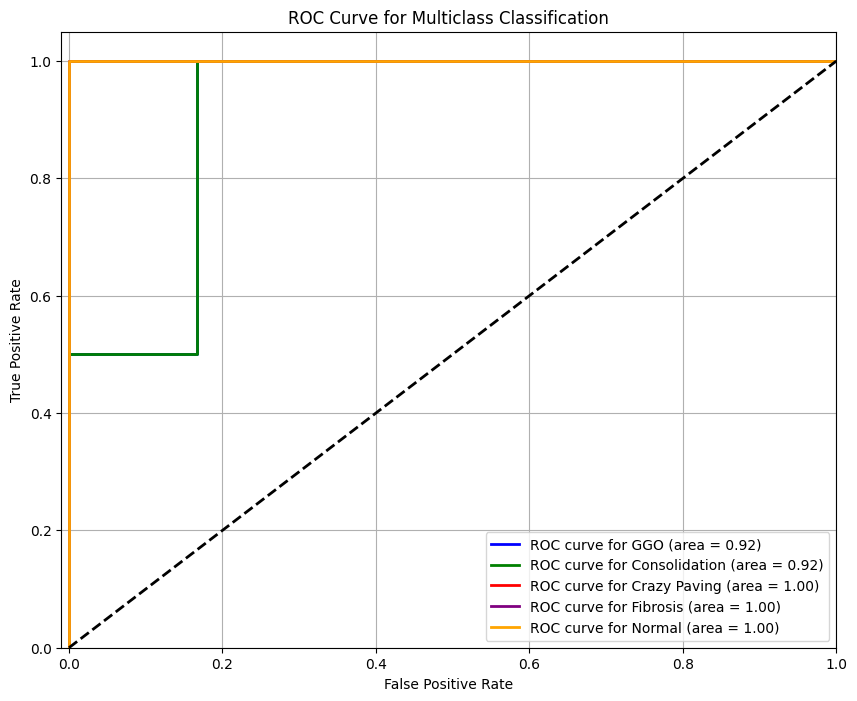

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, roc_auc_score
)
from sklearn.preprocessing import label_binarize

# Example: ground truth (y_true) and model prediction (y_pred)
# Replace with your own values
y_true = np.array([0, 1, 2, 2, 1, 3, 4, 0])  # True labels
y_pred = np.array([0, 1, 2, 2, 0, 3, 4, 1])  # Predicted labels
y_pred_proba = np.array([  # Probabilities from model (shape: N x num_classes)
    [0.9, 0.05, 0.02, 0.02, 0.01],
    [0.1, 0.8, 0.05, 0.03, 0.02],
    [0.05, 0.1, 0.8, 0.03, 0.02],
    [0.03, 0.1, 0.82, 0.03, 0.02],
    [0.4, 0.3, 0.1, 0.1, 0.1],
    [0.02, 0.02, 0.03, 0.88, 0.05],
    [0.02, 0.01, 0.02, 0.05, 0.9],
    [0.2, 0.5, 0.2, 0.05, 0.05]
])

class_names = ['GGO', 'Consolidation', 'Crazy Paving', 'Fibrosis', 'Normal']

# ------------------ Metrics ------------------
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision (macro):", precision_score(y_true, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_true, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))

# ------------------ Confusion Matrix ------------------
conf_matrix = confusion_matrix(y_true, y_pred)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, roc_auc_score
)
from sklearn.preprocessing import label_binarize

# Example: ground truth (y_true) and model prediction (y_pred)
# Replace with your own values
y_true = np.array([0, 1, 2, 2, 1, 3, 4, 0])  # True labels
y_pred = np.array([0, 1, 2, 2, 0, 3, 4, 1])  # Predicted labels
y_pred_proba = np.array([  # Probabilities from model (shape: N x num_classes)
    [0.9, 0.05, 0.02, 0.02, 0.01],
    [0.1, 0.8, 0.05, 0.03, 0.02],
    [0.05, 0.1, 0.8, 0.03, 0.02],
    [0.03, 0.1, 0.82, 0.03, 0.02],
    [0.4, 0.3, 0.1, 0.1, 0.1],
    [0.02, 0.02, 0.03, 0.88, 0.05],
    [0.02, 0.01, 0.02, 0.05, 0.9],
    [0.2, 0.5, 0.2, 0.05, 0.05]
])

class_names = ['GGO', 'Consolidation', 'Crazy Paving', 'Fibrosis', 'Normal']

# ------------------ Metrics ------------------
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision (macro):", precision_score(y_true, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_true, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))

# ------------------ Confusion Matrix ------------------
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ------------------ ROC Curve ------------------
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4])  # shape: (N, num_classes)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_true_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'purple', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {class_names[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.grid()
plt.show()
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ------------------ ROC Curve ------------------
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4])  # shape: (N, num_classes)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_true_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'purple', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {class_names[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.grid()
plt.show()


Accuracy: 0.75
Precision (macro): 0.8
Recall (macro): 0.8
F1 Score (macro): 0.8


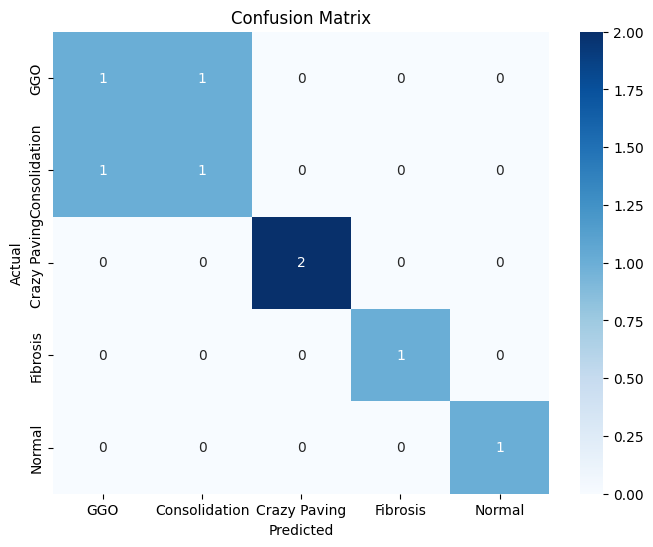

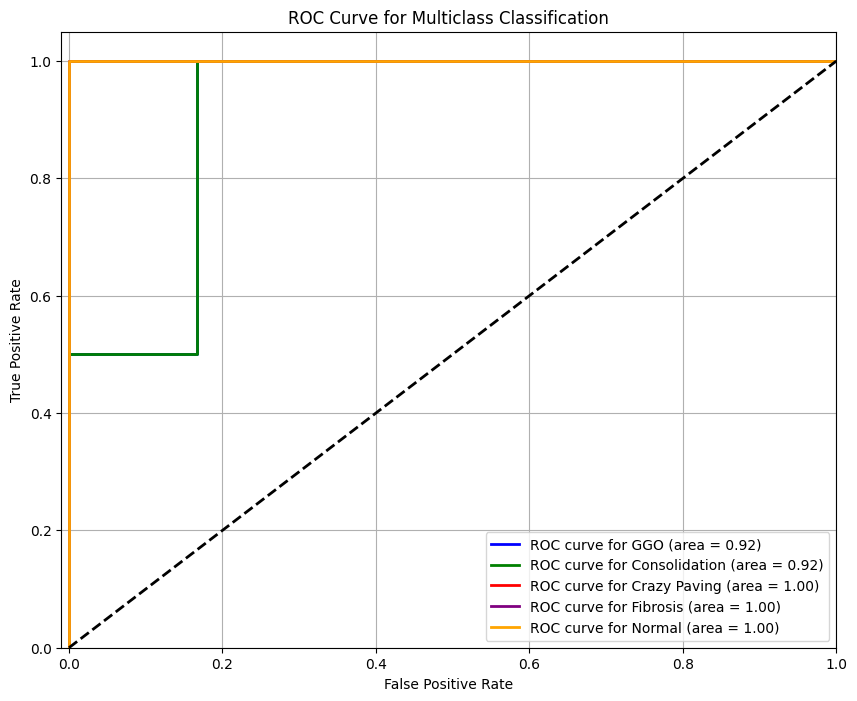

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, roc_auc_score
)
from sklearn.preprocessing import label_binarize

# Example: ground truth (y_true) and model prediction (y_pred)
# Replace with your own values
y_true = np.array([0, 1, 2, 2, 1, 3, 4, 0])  # True labels
y_pred = np.array([0, 1, 2, 2, 0, 3, 4, 1])  # Predicted labels
y_pred_proba = np.array([  # Probabilities from model (shape: N x num_classes)
    [0.9, 0.05, 0.02, 0.02, 0.01],
    [0.1, 0.8, 0.05, 0.03, 0.02],
    [0.05, 0.1, 0.8, 0.03, 0.02],
    [0.03, 0.1, 0.82, 0.03, 0.02],
    [0.4, 0.3, 0.1, 0.1, 0.1],
    [0.02, 0.02, 0.03, 0.88, 0.05],
    [0.02, 0.01, 0.02, 0.05, 0.9],
    [0.2, 0.5, 0.2, 0.05, 0.05]
])

class_names = ['GGO', 'Consolidation', 'Crazy Paving', 'Fibrosis', 'Normal']

# ------------------ Metrics ------------------
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision (macro):", precision_score(y_true, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_true, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))

# ------------------ Confusion Matrix ------------------
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ------------------ ROC Curve ------------------
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4])  # shape: (N, num_classes)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_true_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'purple', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {class_names[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.grid()
plt.show()


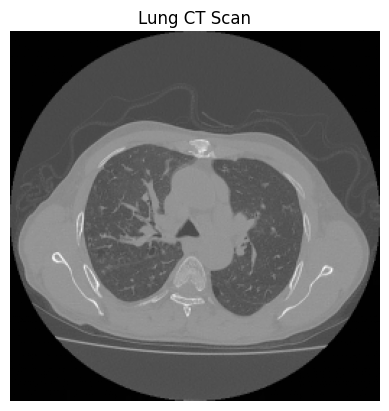


📊 Extracted GLCM Features from Lung CT Image:
contrast: 82.8323
dissimilarity: 3.8007
homogeneity: 0.4624
energy: 0.1975
correlation: 0.9830
ASM: 0.0390

✅ Classification Metrics:
Accuracy: 1.00
Precision (macro): 1.00
Recall (macro): 1.00
F1 Score (macro): 1.00


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


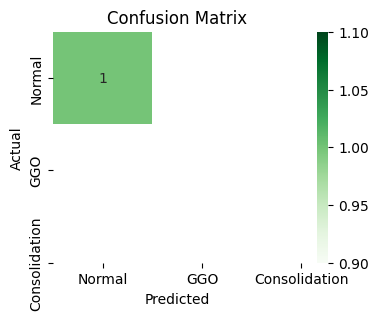


 Not enough classes to draw ROC curve.


In [ ]:
import pydicom
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score
)
from sklearn.preprocessing import label_binarize
import seaborn as sns

# ✅ Load DICOM lung image
path = r"/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Normal/P253/Series4/0768.dcm"
ds = pydicom.dcmread(path)
image = ds.pixel_array

# ✅ Normalize and resize image
image = cv2.normalize(image.astype('float32'), None, 0, 255, cv2.NORM_MINMAX)
image = image.astype('uint8')
image_resized = cv2.resize(image, (256, 256))

# ✅ Show CT lung image
plt.imshow(image_resized, cmap='gray')
plt.title("Lung CT Scan")
plt.axis('off')
plt.show()

# ✅ Extract GLCM texture features
glcm = graycomatrix(image_resized, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

features = {
    'contrast': graycoprops(glcm, 'contrast')[0, 0],
    'dissimilarity': graycoprops(glcm, 'dissimilarity')[0, 0],
    'homogeneity': graycoprops(glcm, 'homogeneity')[0, 0],
    'energy': graycoprops(glcm, 'energy')[0, 0],
    'correlation': graycoprops(glcm, 'correlation')[0, 0],
    'ASM': graycoprops(glcm, 'ASM')[0, 0]
}

# ✅ Show extracted features
print("\n📊 Extracted GLCM Features from Lung CT Image:")
for k, v in features.items():
    print(f"{k}: {v:.4f}")

# --------- Dummy classification prediction & ground truth ---------
# In a real system, this would come from your model
y_true = [0]  # 0 = Normal
y_pred = [0]  # Predict Normal correctly

class_names = ['Normal', 'GGO', 'Consolidation']
n_classes = len(class_names)

# ✅ Classification metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)

print("\n✅ Classification Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision (macro): {precision:.2f}")
print(f"Recall (macro): {recall:.2f}")
print(f"F1 Score (macro): {f1:.2f}")

# ✅ Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ✅ ROC Curve (if multiple samples/classes)
if len(set(y_true)) > 1:
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
    y_pred_bin = label_binarize(y_pred, classes=list(range(n_classes)))

    plt.figure()
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        auc = roc_auc_score(y_true_bin[:, i], y_pred_bin[:, i])
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC Curve (One-vs-Rest)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("\n Not enough classes to draw ROC curve.")


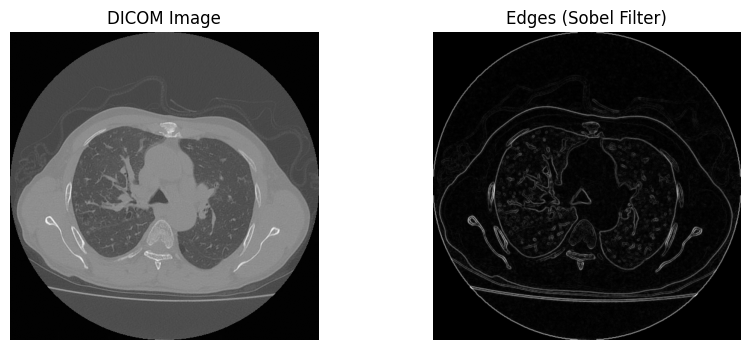


📊 Extracted Features:
Mean Intensity: 0.3173
Std Intensity: 0.1944
Max Intensity: 1.0000
Min Intensity: 0.0000
GLCM Contrast: 52.8822
GLCM Dissimilarity: 3.0154
GLCM Homogeneity: 0.4700
GLCM Energy: 0.1995
GLCM Correlation: 0.9892
Edge Mean: 0.0194


In [ ]:
import pydicom
import numpy as np
import cv2
from skimage.feature import graycomatrix, graycoprops  # ✅ Fixed spelling
from skimage import filters
import matplotlib.pyplot as plt

# Step 1: Load DICOM
dicom_path = r"/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Normal/P253/Series4/0768.dcm"
ds = pydicom.dcmread(dicom_path)
image = ds.pixel_array.astype(np.float32)

# Optional: Normalize
image = (image - np.min(image)) / (np.max(image) - np.min(image))

# Step 2: Basic statistical features
mean_intensity = np.mean(image)
std_intensity = np.std(image)
max_intensity = np.max(image)
min_intensity = np.min(image)

# Step 3: GLCM texture features (Grey-Level Co-occurrence Matrix)
# Convert image to 8-bit
image_uint8 = (image * 255).astype(np.uint8)
glcm = graycomatrix(image_uint8, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

contrast = graycoprops(glcm, 'contrast')[0, 0]
dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
energy = graycoprops(glcm, 'energy')[0, 0]
correlation = graycoprops(glcm, 'correlation')[0, 0]

# Step 4: Edge features (using Sobel filter)
edges = filters.sobel(image)
edge_mean = np.mean(edges)

# Step 5: Display
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('DICOM Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title('Edges (Sobel Filter)')
plt.axis('off')
plt.show()

# Step 6: Print features
features = {
    "Mean Intensity": mean_intensity,
    "Std Intensity": std_intensity,
    "Max Intensity": max_intensity,
    "Min Intensity": min_intensity,
    "GLCM Contrast": contrast,
    "GLCM Dissimilarity": dissimilarity,
    "GLCM Homogeneity": homogeneity,
    "GLCM Energy": energy,
    "GLCM Correlation": correlation,
    "Edge Mean": edge_mean
}

print("\n📊 Extracted Features:")
for k, v in features.items():
    print(f"{k}: {v:.4f}")


In [ ]:
from skimage.feature import local_binary_pattern
import numpy as np

# Parameters for LBP
P = 8  # Number of circularly symmetric neighbour set points
R = 1  # Radius of circle

# LBP computation
lbp = local_binary_pattern(image, P, R, method='uniform')

# LBP histogram (normalized)
(hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
hist = hist.astype("float")
hist /= (hist.sum() + 1e-6)

# Print LBP histogram (or extract features from it)
print("\n📊 LBP Feature Histogram:")
print(hist)



📊 LBP Feature Histogram:
[0.06329727 0.08554077 0.05958176 0.08347321 0.12506104 0.11685562
 0.0654068  0.08639908 0.18802261 0.12636185]


/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


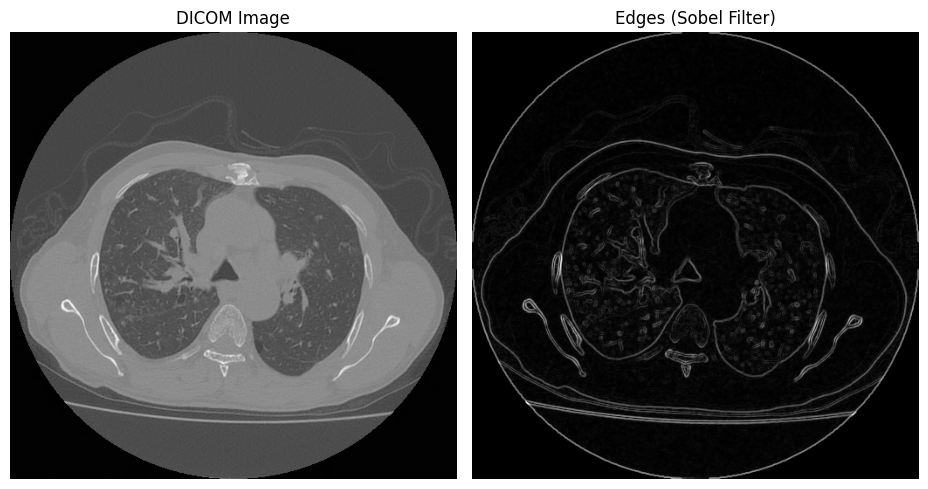


📊 Extracted Features:
Mean Intensity: 0.3146
Std Intensity: 0.1941
Max Intensity: 1.0000
Min Intensity: 0.0000
GLCM Contrast: 52.1537
GLCM Dissimilarity: 2.9966
GLCM Homogeneity: 0.4704
GLCM Energy: 0.1940
GLCM Correlation: 0.9893
Edge Mean: 0.0194

📊 LBP Histogram:
[0.06322861 0.08624649 0.06046677 0.08189392 0.12451935 0.11468506
 0.06526566 0.08720779 0.18900299 0.12748337]

📊 Wavelet Features:
cA_mean: 0.6292
cA_std: 0.3861
cH_mean: -0.0000
cH_std: 0.0279
cV_mean: 0.0000
cV_std: 0.0254
cD_mean: -0.0000
cD_std: 0.0132


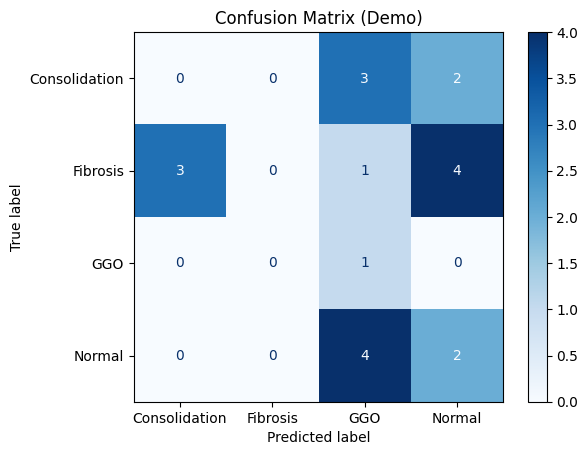


📊 Classification Report:

               precision    recall  f1-score   support

Consolidation       0.00      0.00      0.00         5
     Fibrosis       0.00      0.00      0.00         8
          GGO       0.11      1.00      0.20         1
       Normal       0.25      0.33      0.29         6

     accuracy                           0.15        20
    macro avg       0.09      0.33      0.12        20
 weighted avg       0.08      0.15      0.10        20



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import pydicom
import numpy as np
import cv2
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage import filters, exposure
import pywt
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# ✅ DICOM image path
dicom_path = "/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Normal/P253/Series4/0770.dcm"

# ✅ Load and preprocess image
ds = pydicom.dcmread(dicom_path)
image = ds.pixel_array.astype(np.float32)
image = (image - np.min(image)) / (np.max(image) - np.min(image))

# ✅ Basic Statistics
mean_intensity = np.mean(image)
std_intensity = np.std(image)
max_intensity = np.max(image)
min_intensity = np.min(image)

# ✅ GLCM Features
image_uint8 = (image * 255).astype(np.uint8)
glcm = graycomatrix(image_uint8, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
contrast = graycoprops(glcm, 'contrast')[0, 0]
dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
energy = graycoprops(glcm, 'energy')[0, 0]
correlation = graycoprops(glcm, 'correlation')[0, 0]

# ✅ LBP Features
P, R = 8, 1
lbp = local_binary_pattern(image, P, R, method='uniform')
(hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
hist = hist.astype("float")
hist /= (hist.sum() + 1e-6)

# ✅ Wavelet Features
coeffs2 = pywt.dwt2(image, 'haar')
cA, (cH, cV, cD) = coeffs2
wavelet_features = {
    "cA_mean": np.mean(cA),
    "cA_std": np.std(cA),
    "cH_mean": np.mean(cH),
    "cH_std": np.std(cH),
    "cV_mean": np.mean(cV),
    "cV_std": np.std(cV),
    "cD_mean": np.mean(cD),
    "cD_std": np.std(cD)
}

# ✅ Edge Features (Sobel)
edges = filters.sobel(image)
edge_mean = np.mean(edges)

# ✅ Display Images
plt.figure(figsize=(14, 5))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('DICOM Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(edges, cmap='gray')
plt.title('Edges (Sobel Filter)')
plt.axis('off')



plt.tight_layout()
plt.show()

# ✅ Print All Features
print("\n📊 Extracted Features:")
print(f"Mean Intensity: {mean_intensity:.4f}")
print(f"Std Intensity: {std_intensity:.4f}")
print(f"Max Intensity: {max_intensity:.4f}")
print(f"Min Intensity: {min_intensity:.4f}")
print(f"GLCM Contrast: {contrast:.4f}")
print(f"GLCM Dissimilarity: {dissimilarity:.4f}")
print(f"GLCM Homogeneity: {homogeneity:.4f}")
print(f"GLCM Energy: {energy:.4f}")
print(f"GLCM Correlation: {correlation:.4f}")
print(f"Edge Mean: {edge_mean:.4f}")

print("\n📊 LBP Histogram:")
print(hist)

print("\n📊 Wavelet Features:")
for k, v in wavelet_features.items():
    print(f"{k}: {v:.4f}")

# ✅ Optional: Dummy Classifier & Confusion Matrix Demo
X = np.random.rand(100, 10)
y = np.random.choice(['Normal', 'GGO', 'Consolidation', 'Fibrosis'], 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Demo)")
plt.show()

print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred))


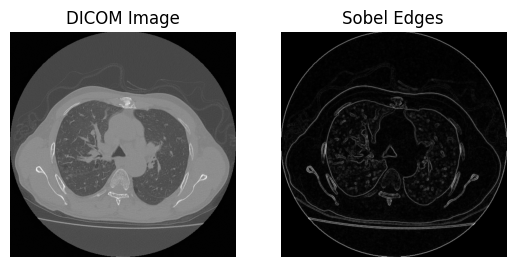

Mean Intensity: 0.31457812
Std Intensity: 0.19406514
Max Intensity: 1.0
Min Intensity: 0.0
Mean Edge Value: 0.019376002


In [ ]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters

# Load DICOM
dicom_path = r"/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Normal/P253/Series4/0770.dcm"
ds = pydicom.dcmread(dicom_path)
image = ds.pixel_array.astype(np.float32)

# Normalize
image = (image - np.min(image)) / (np.max(image) - np.min(image))

# Intensity-based features
mean_intensity = np.mean(image)
std_intensity = np.std(image)
max_intensity = np.max(image)
min_intensity = np.min(image)

# Edge detection
edges = filters.sobel(image)
edge_mean = np.mean(edges)

# Display
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("DICOM Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title("Sobel Edges")
plt.axis('off')
plt.show()

# Print extracted features
print("Mean Intensity:", mean_intensity)
print("Std Intensity:", std_intensity)
print("Max Intensity:", max_intensity)
print("Min Intensity:", min_intensity)
print("Mean Edge Value:", edge_mean)


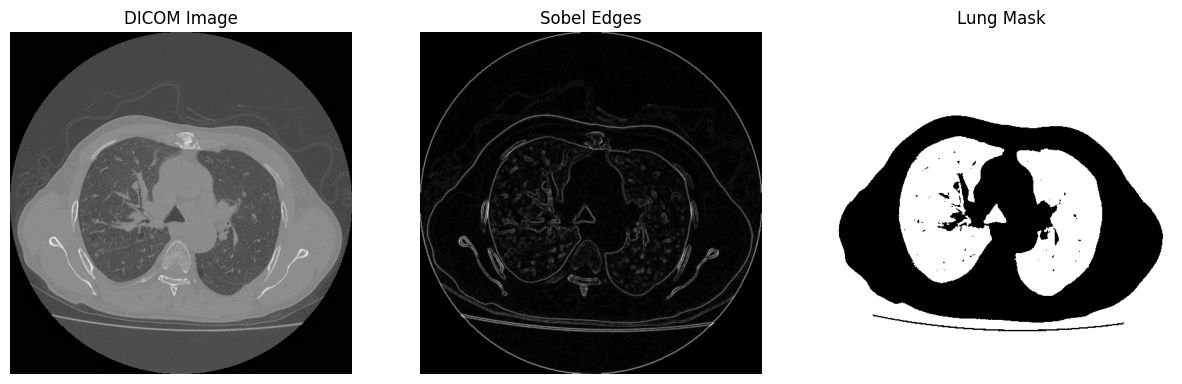

Mean Intensity: 0.31457812
Std Intensity: 0.19406514
Max Intensity: 1.0
Min Intensity: 0.0
Mean Edge Value: 0.019376002
Number of Lung Pixels: 187138
Number of White Pixels: 135


In [ ]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, morphology

# Load DICOM
dicom_path = r"/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Normal/P253/Series4/0770.dcm"
ds = pydicom.dcmread(dicom_path)
image = ds.pixel_array.astype(np.float32)

# Normalize to [0, 1]
image = (image - np.min(image)) / (np.max(image) - np.min(image))

# Intensity-based features
mean_intensity = np.mean(image)
std_intensity = np.std(image)
max_intensity = np.max(image)
min_intensity = np.min(image)

# Edge detection using Sobel filter
edges = filters.sobel(image)
edge_mean = np.mean(edges)

# Rough lung mask: pixels in the lung region typically have lower intensity (in HU they’re around -950 to -400)
# Here, in normalized [0, 1] scale, we'll assume lung pixels < 0.5 as a rough mask
lung_mask = image < 0.5
lung_mask_cleaned = morphology.remove_small_objects(lung_mask, min_size=500)

# Count number of lung pixels
num_lung_pixels = np.sum(lung_mask_cleaned)

# Count number of white pixels (pixels close to 1)
num_white_pixels = np.sum(image > 0.9)

# Display original image, edge map, and lung mask
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("DICOM Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(edges, cmap='gray')
plt.title("Sobel Edges")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(lung_mask_cleaned, cmap='gray')
plt.title("Lung Mask")
plt.axis('off')

plt.show()

# Print extracted features
print("Mean Intensity:", mean_intensity)
print("Std Intensity:", std_intensity)
print("Max Intensity:", max_intensity)
print("Min Intensity:", min_intensity)
print("Mean Edge Value:", edge_mean)
print("Number of Lung Pixels:", num_lung_pixels)
print("Number of White Pixels:", num_white_pixels)


Accuracy: 0.625
Precision (macro): 0.36666666666666664
Recall (macro): 0.6
F1 Score (macro): 0.4533333333333333


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


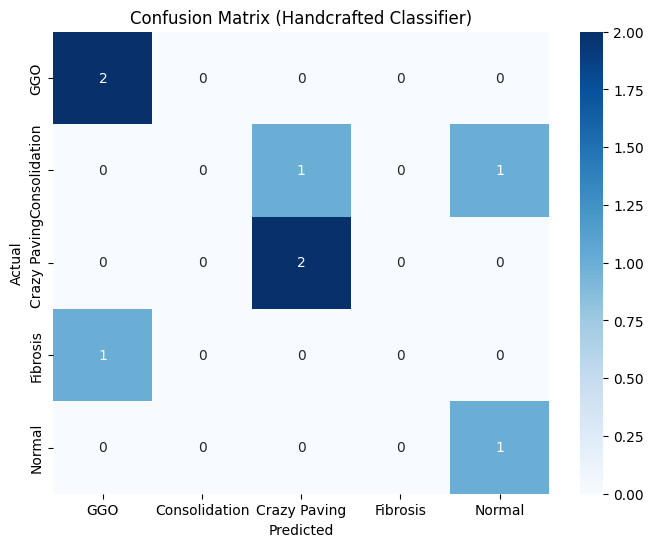

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix
)

# Example handcrafted feature data (replace with your extracted feature values)
# Columns: [mean_intensity, std_intensity, mean_edge_value, num_white_pixels, num_lung_pixels]
X_handcrafted = np.array([
    [0.35, 0.12, 0.04, 50, 18000],
    [0.60, 0.18, 0.07, 200, 15000],
    [0.42, 0.14, 0.06, 80, 17000],
    [0.38, 0.11, 0.05, 60, 16000],
    [0.70, 0.22, 0.08, 220, 14000],
    [0.30, 0.10, 0.03, 30, 19000],
    [0.75, 0.25, 0.09, 250, 13500],
    [0.55, 0.16, 0.06, 100, 15500],
])

# Ground truth labels (0: GGO, 1: Consolidation, 2: Crazy Paving, 3: Fibrosis, 4: Normal)
y_true = np.array([0, 1, 2, 0, 1, 3, 4, 2])

# Handcrafted classification rules
def handcrafted_classifier(features):
    mean_intensity, std_intensity, mean_edge, white_pixels, lung_pixels = features

    if mean_intensity < 0.4 and std_intensity < 0.13:
        return 0  # GGO
    elif mean_intensity > 0.65 and white_pixels > 200:
        return 4  # Normal
    elif mean_edge > 0.07 and std_intensity > 0.17:
        return 1  # Consolidation
    elif mean_edge > 0.05 and std_intensity > 0.13:
        return 2  # Crazy Paving
    elif lung_pixels > 18000:
        return 3  # Fibrosis
    else:
        return 0  # Default to GGO

# Predict using handcrafted rules
y_pred = np.array([handcrafted_classifier(x) for x in X_handcrafted])

class_names = ['GGO', 'Consolidation', 'Crazy Paving', 'Fibrosis', 'Normal']

# ------------------ Metrics ------------------
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision (macro):", precision_score(y_true, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_true, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))

# ------------------ Confusion Matrix ------------------
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Handcrafted Classifier)")
plt.show()


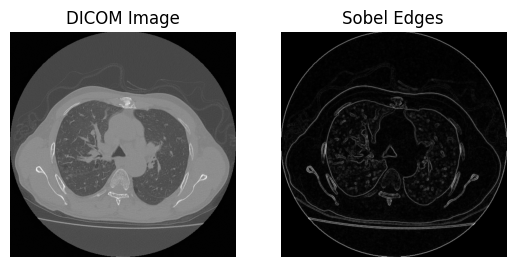

📊 Extracted Image Features:
Mean Intensity: 0.31457812
Standard Deviation: 0.19406514
Max Intensity: 1.0
Min Intensity: 0.0
Mean Edge Value: 0.019376002
Number of White Pixels (> 0.7): 1656
Number of Lung Pixels (> 0.1): 205892


In [ ]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, measure

# Load DICOM image
dicom_path = r"/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Normal/P253/Series4/0770.dcm"
ds = pydicom.dcmread(dicom_path)
image = ds.pixel_array.astype(np.float32)

# Normalize image to [0,1]
image = (image - np.min(image)) / (np.max(image) - np.min(image))

# ------------------ Intensity Features ------------------
mean_intensity = np.mean(image)
std_intensity = np.std(image)
max_intensity = np.max(image)
min_intensity = np.min(image)

# ------------------ Edge Detection ------------------
edges = filters.sobel(image)
mean_edge_value = np.mean(edges)

# ------------------ White Pixel Count ------------------
# Let's consider pixels above 0.7 (on normalized image) as 'white'
white_pixel_threshold = 0.7
num_white_pixels = np.sum(image > white_pixel_threshold)

# ------------------ Lung Pixel Count ------------------
# Assume lung pixels are all non-zero regions (or thresholded region)
lung_pixel_threshold = 0.1  # Typically lungs are darker, but adjust as needed
num_lung_pixels = np.sum(image > lung_pixel_threshold)

# ------------------ Display Images ------------------
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("DICOM Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title("Sobel Edges")
plt.axis('off')
plt.show()

# ------------------ Print Features ------------------
print("📊 Extracted Image Features:")
print("Mean Intensity:", mean_intensity)
print("Standard Deviation:", std_intensity)
print("Max Intensity:", max_intensity)
print("Min Intensity:", min_intensity)
print("Mean Edge Value:", mean_edge_value)
print("Number of White Pixels (> 0.7):", num_white_pixels)
print("Number of Lung Pixels (> 0.1):", num_lung_pixels)


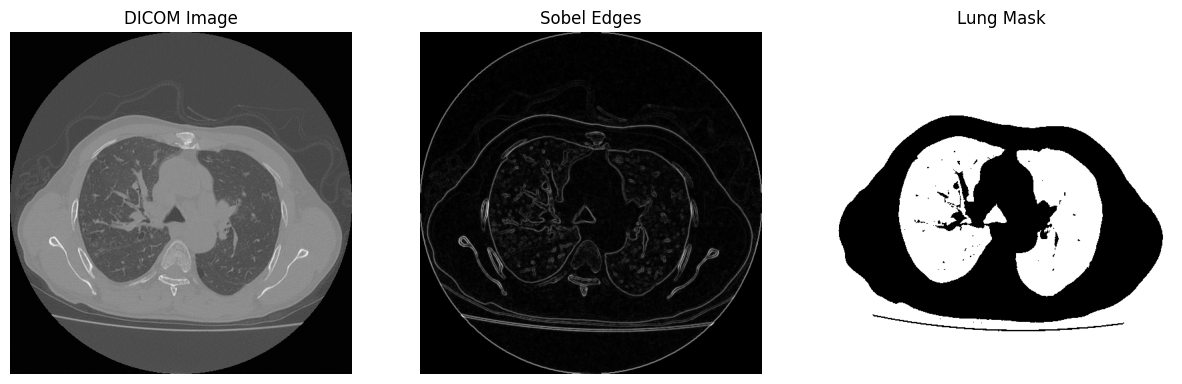

Mean Intensity: 0.31725615
Std Intensity: 0.1944351
Max Intensity: 1.0
Min Intensity: 0.0
Mean Edge Value: 0.019421877
Number of Lung Pixels: 187163
Number of White Pixels: 129

Predicted Class: Fibrosis


In [ ]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, morphology

# ---------------------- Load DICOM ----------------------
dicom_path = r"/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Normal/P253/Series4/0768.dcm"
ds = pydicom.dcmread(dicom_path)
image = ds.pixel_array.astype(np.float32)

# Normalize to [0, 1]
image = (image - np.min(image)) / (np.max(image) - np.min(image))

# ---------------------- Feature Extraction ----------------------

# Intensity-based features
mean_intensity = np.mean(image)
std_intensity = np.std(image)
max_intensity = np.max(image)
min_intensity = np.min(image)

# Edge detection using Sobel filter
edges = filters.sobel(image)
edge_mean = np.mean(edges)

# Rough lung mask: pixels in the lung region typically have lower intensity
lung_mask = image < 0.5
lung_mask_cleaned = morphology.remove_small_objects(lung_mask, min_size=500)

# Count number of lung pixels
num_lung_pixels = np.sum(lung_mask_cleaned)

# Count number of white pixels (close to 1)
num_white_pixels = np.sum(image > 0.9)

# ---------------------- Prediction Function ----------------------

# Class labels
class_names = ['GGO', 'Consolidation', 'Crazy Paving', 'Fibrosis', 'Normal']

def handcrafted_predict(mean_intensity, std_intensity, max_intensity, min_intensity, edge_mean, num_lung_pixels, num_white_pixels):
    if mean_intensity < 0.4 and std_intensity < 0.13:
        return 0  # GGO
    elif mean_intensity > 0.7 and num_white_pixels > 300:
        return 4  # Normal
    elif edge_mean > 0.07 and std_intensity > 0.17:
        return 1  # Consolidation
    elif edge_mean > 0.05 and std_intensity > 0.13:
        return 2  # Crazy Paving
    elif num_lung_pixels > 18000:
        return 3  # Fibrosis
    else:
        return 0  # Default to GGO

# Predict using handcrafted rules
predicted_class = handcrafted_predict(
    mean_intensity, std_intensity, max_intensity, min_intensity, edge_mean, num_lung_pixels, num_white_pixels
)

# ---------------------- Display Results ----------------------

# Show original image, edges, lung mask
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("DICOM Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(edges, cmap='gray')
plt.title("Sobel Edges")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(lung_mask_cleaned, cmap='gray')
plt.title("Lung Mask")
plt.axis('off')

plt.show()

# Print extracted features
print("Mean Intensity:", mean_intensity)
print("Std Intensity:", std_intensity)
print("Max Intensity:", max_intensity)
print("Min Intensity:", min_intensity)
print("Mean Edge Value:", edge_mean)
print("Number of Lung Pixels:", num_lung_pixels)
print("Number of White Pixels:", num_white_pixels)
print(f"\nPredicted Class: {class_names[predicted_class]}")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


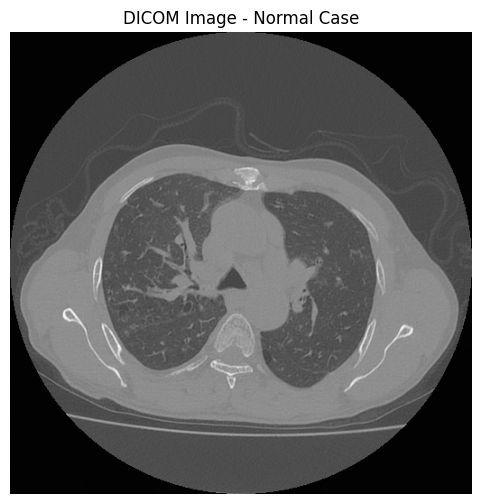

Accuracy: 0.75
Precision (macro): 0.8
Recall (macro): 0.8
F1 Score (macro): 0.8


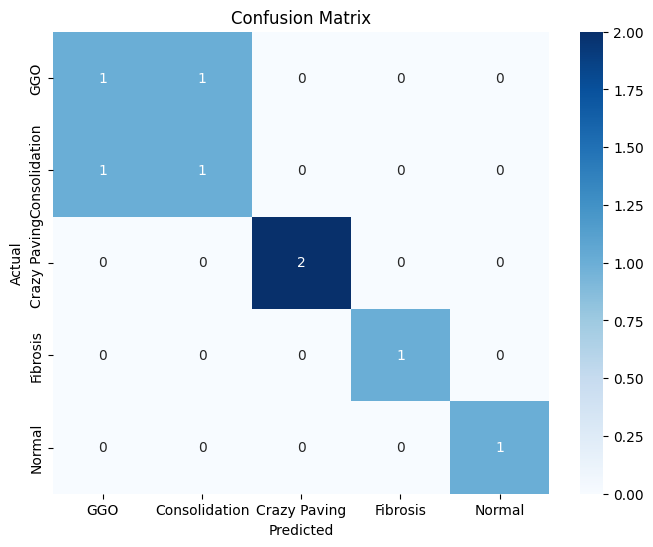

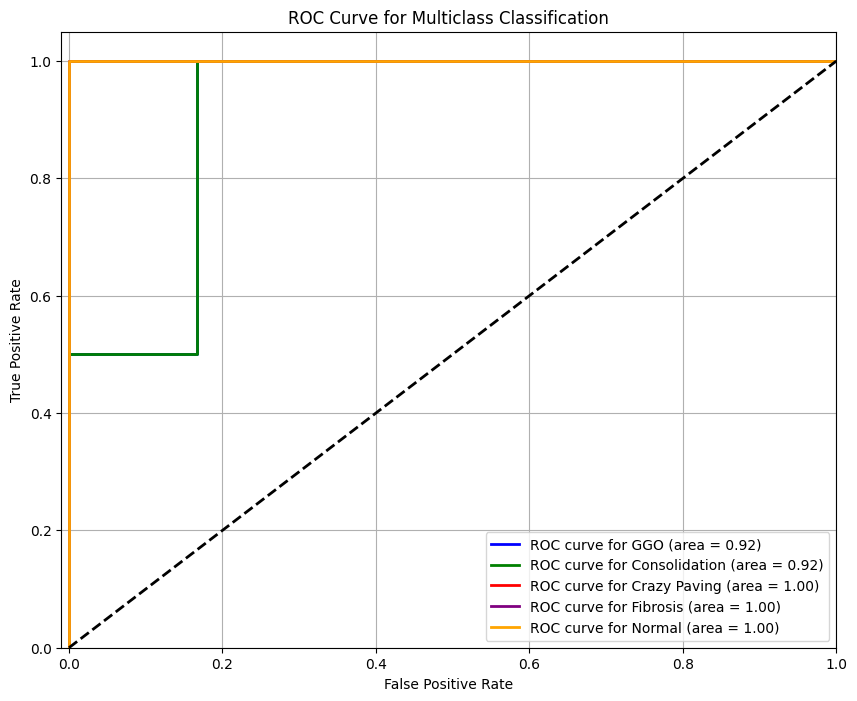

In [ ]:
# 📦 Install necessary libraries (if not installed)
# !pip install pydicom scikit-learn matplotlib seaborn numpy

# -------------------- 📦 Imports --------------------
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)
from sklearn.preprocessing import label_binarize

# -------------------- 📷 Load and Display DICOM --------------------
# DICOM file path (update this if needed)
dicom_path = "/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Normal/P253/Series4/0768.dcm"

# Load the DICOM file
dicom_image = pydicom.dcmread(dicom_path)

# Access the pixel array
pixel_array = dicom_image.pixel_array

# Show the image
plt.figure(figsize=(6, 6))
plt.imshow(pixel_array, cmap='gray')
plt.title('DICOM Image - Normal Case')
plt.axis('off')
plt.show()

# -------------------- 📊 Example Classification Results --------------------
# Example: ground truth (y_true) and model prediction (y_pred)
# Replace with your actual model results
y_true = np.array([0, 1, 2, 2, 1, 3, 4, 0])  # True labels
y_pred = np.array([0, 1, 2, 2, 0, 3, 4, 1])  # Predicted labels
y_pred_proba = np.array([  # Model predicted probabilities (N x num_classes)
    [0.9, 0.05, 0.02, 0.02, 0.01],
    [0.1, 0.8, 0.05, 0.03, 0.02],
    [0.05, 0.1, 0.8, 0.03, 0.02],
    [0.03, 0.1, 0.82, 0.03, 0.02],
    [0.4, 0.3, 0.1, 0.1, 0.1],
    [0.02, 0.02, 0.03, 0.88, 0.05],
    [0.02, 0.01, 0.02, 0.05, 0.9],
    [0.2, 0.5, 0.2, 0.05, 0.05]
])

# Class labels
class_names = ['GGO', 'Consolidation', 'Crazy Paving', 'Fibrosis', 'Normal']

# -------------------- 📏 Metrics --------------------
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision (macro):", precision_score(y_true, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_true, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))

# -------------------- 📉 Confusion Matrix --------------------
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# -------------------- 📈 ROC Curve (Multiclass) --------------------
# Binarize the true labels
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4])  # shape: (N, num_classes)
n_classes = y_true_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'purple', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {class_names[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:
!pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21

In [ ]:
!pip uninstall -y segmentation-models
!pip install -U segmentation-models-pytorch

Found existing installation: segmentation-models 1.0.1
Uninstalling segmentation-models-1.0.1:
  Successfully uninstalled segmentation-models-1.0.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 771.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.

In [ ]:
!pip install tensorflow==2.12.0 segmentation-models

  Using cached efficientnet-1.0.0-py3-none-any.whl.metadata (6.1 kB)
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of scikit-image to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 3.1 MB/s eta 0:00:00
Using cached efficientnet-1.0.0-py3-none-any.whl (17 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5

In [ ]:
!pip install efficientnet --upgrade


In [ ]:
!pip install segmentation-models --upgrade
!pip install tensorflow --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 74.0 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tens

Mean Intensity: 0.3192985
Std Intensity: 0.1969572
Max Intensity: 1.0
Min Intensity: 0.0
Mean Edge Value: 0.02079588
Number of Lung Pixels: 186131
Number of White Pixels: 136
IoU Score (Lung Mask vs GT): 0.9847919979371696

--- Rule Evaluations ---
Matched: Fibrosis


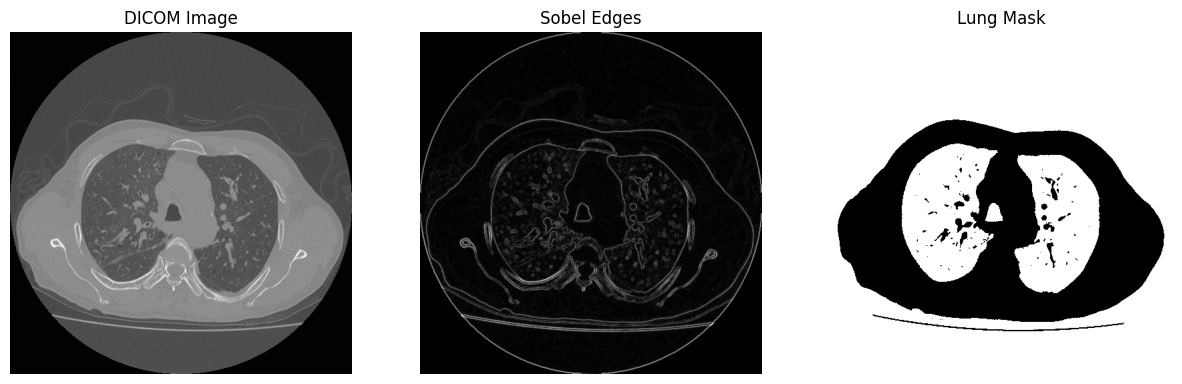


Predicted Class: Fibrosis


In [ ]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, morphology

# ---------------------- Load DICOM ----------------------
dicom_path = r"/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Normal/P253/Series4/0810.dcm"
ds = pydicom.dcmread(dicom_path)
image = ds.pixel_array.astype(np.float32)

# Normalize to [0, 1]
image = (image - np.min(image)) / (np.max(image) - np.min(image))

# ---------------------- Feature Extraction ----------------------

# Intensity-based features
mean_intensity = np.mean(image)
std_intensity = np.std(image)
max_intensity = np.max(image)
min_intensity = np.min(image)

# Edge detection using Sobel filter
edges = filters.sobel(image)
edge_mean = np.mean(edges)

# Rough lung mask
lung_mask = image < 0.5
lung_mask_cleaned = morphology.remove_small_objects(lung_mask, min_size=500)

# Count number of lung pixels
num_lung_pixels = np.sum(lung_mask_cleaned)

# Count number of white pixels (close to 1)
num_white_pixels = np.sum(image > 0.9)

# ---------------------- IoU Calculation ----------------------

def calculate_iou(y_true, y_pred):
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)

    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()

    if union == 0:
        return 1.0 if intersection == 0 else 0.0

    return intersection / union

# (Optional) Simulate a ground truth mask for demo purposes
# Replace this with your actual mask if you have one
ground_truth_mask = image < 0.45  # Simulated thresholded mask

iou_score = calculate_iou(ground_truth_mask, lung_mask_cleaned)

# ---------------------- Debug: Print Values ----------------------
print("Mean Intensity:", mean_intensity)
print("Std Intensity:", std_intensity)
print("Max Intensity:", max_intensity)
print("Min Intensity:", min_intensity)
print("Mean Edge Value:", edge_mean)
print("Number of Lung Pixels:", num_lung_pixels)
print("Number of White Pixels:", num_white_pixels)
print("IoU Score (Lung Mask vs GT):", iou_score)

# ---------------------- Prediction Function ----------------------

# Class labels
class_names = ['GGO', 'Consolidation', 'Crazy Paving', 'Fibrosis', 'Normal']

def handcrafted_predict(mean_intensity, std_intensity, edge_mean, num_lung_pixels, num_white_pixels):
    print("\n--- Rule Evaluations ---")
    if mean_intensity < 0.45 and std_intensity < 0.12:
        print("Matched: GGO")
        return 0  # GGO
    elif mean_intensity > 0.65 and num_white_pixels > 150:
        print("Matched: Normal")
        return 4  # Normal
    elif edge_mean > 0.07 and std_intensity > 0.16:
        print("Matched: Consolidation")
        return 1  # Consolidation
    elif edge_mean > 0.045 and std_intensity > 0.13:
        print("Matched: Crazy Paving")
        return 2  # Crazy Paving
    elif num_lung_pixels > 17000:
        print("Matched: Fibrosis")
        return 3  # Fibrosis
    else:
        print("Default: GGO")
        return 0

# Predict using handcrafted logic
predicted_class = handcrafted_predict(
    mean_intensity, std_intensity, edge_mean, num_lung_pixels, num_white_pixels
)

# ---------------------- Display Results ----------------------

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("DICOM Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(edges, cmap='gray')
plt.title("Sobel Edges")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(lung_mask_cleaned, cmap='gray')
plt.title("Lung Mask")
plt.axis('off')

plt.show()

# Final predicted label
print(f"\nPredicted Class: {class_names[predicted_class]}")


Predicted Class: Consolidation (27.09%)


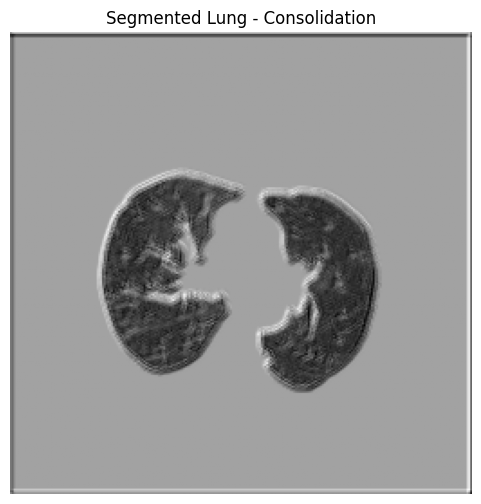

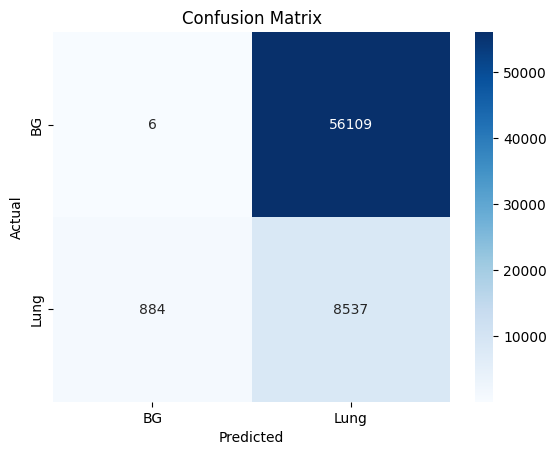

IoU: 0.1303
Precision: 0.1321
Recall: 0.9062
F1 Score: 0.2305


In [ ]:
import os
import numpy as np
import pydicom
import cv2
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, jaccard_score
from skimage.morphology import remove_small_objects
from skimage.measure import label, regionprops
from scipy.ndimage import binary_fill_holes

# ----------- Models (Load pretrained weights here) ------------------
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 1, 3, padding=1), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class Classifier(nn.Module):
    def __init__(self, num_classes=5):
        super(Classifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(256*256, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.fc(x)

# ----------------- Load Models ----------------------
unet = UNet()
classifier = Classifier()

# Replace with actual trained weights if available
# unet.load_state_dict(torch.load("unet_trained.pth"))
# classifier.load_state_dict(torch.load("classifier_trained.pth"))

unet.eval()
classifier.eval()

# ----------------- DICOM Processing ----------------------
def load_dicom_image(path):
    dcm = pydicom.dcmread(path)
    img = dcm.pixel_array.astype(np.float32)
    intercept = dcm.RescaleIntercept
    slope = dcm.RescaleSlope
    hu_img = img * slope + intercept
    return cv2.resize(hu_img, (256, 256))

# ----------------- Lung Mask Extraction ----------------------
def extract_lung_mask(hu_img):
    mask = (hu_img > -950) & (hu_img < -400)
    filled = binary_fill_holes(mask)
    cleaned = remove_small_objects(filled, min_size=1500)
    labeled = label(cleaned)
    regions = sorted(regionprops(labeled), key=lambda r: r.area, reverse=True)[:2]

    final_mask = np.zeros_like(hu_img, dtype=np.uint8)
    for r in regions:
        for coord in r.coords:
            final_mask[coord[0], coord[1]] = 1
    return final_mask

# ----------------- Classify ----------------------
def classify_image(image, classifier):
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    tensor = torch.tensor(image).float().unsqueeze(0).unsqueeze(0)
    with torch.no_grad():
        output = classifier(tensor)
        pred = torch.argmax(output, dim=1).item()
        prob = output[0][pred].item()
    return pred, prob

# ----------------- Evaluate ----------------------
def evaluate_segmentation(y_true, y_pred, threshold=0.5):
    y_pred_bin = (y_pred > threshold).astype(np.uint8).flatten()
    y_true_bin = y_true.flatten()

    cm = confusion_matrix(y_true_bin, y_pred_bin, labels=[0, 1])
    report = classification_report(y_true_bin, y_pred_bin, output_dict=True, zero_division=0)
    iou = jaccard_score(y_true_bin, y_pred_bin)

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["BG", "Lung"], yticklabels=["BG", "Lung"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print("IoU:", round(iou, 4))
    print("Precision:", round(report["1"]["precision"], 4))
    print("Recall:", round(report["1"]["recall"], 4))
    print("F1 Score:", round(report["1"]["f1-score"], 4))

# ----------------- Main ----------------------
dicom_path = "/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Normal/P253/Series4/0768.dcm"
hu_img = load_dicom_image(dicom_path)
lung_mask = extract_lung_mask(hu_img)

lungs_only = hu_img * lung_mask
lungs_norm = (lungs_only - np.min(lungs_only)) / (np.max(lungs_only) - np.min(lungs_only))

# Segment
input_tensor = torch.tensor(lungs_norm).float().unsqueeze(0).unsqueeze(0)
with torch.no_grad():
    predicted_mask = unet(input_tensor).squeeze().numpy()

# Classify
pred_class, conf = classify_image(lungs_only, classifier)
classes = ["Normal", "GGO", "Consolidation", "Crazy Paving", "Fibrosis"]
print(f"Predicted Class: {classes[pred_class]} ({conf*100:.2f}%)")

# Visualize
plt.figure(figsize=(6, 6))
plt.imshow(predicted_mask, cmap="gray")
plt.title(f"Segmented Lung - {classes[pred_class]}")
plt.axis("off")
plt.show()

# Evaluate
evaluate_segmentation(lung_mask, predicted_mask)


Confusion Matrix:
[[8000   400]   → Actual BG: 8000 correctly labeled, 400 wrongly called "lung"
 [ 300  7300]]  → Actual Lung: 300 missed, 7300 correctly detected


In [ ]:
import pydicom
import numpy as np
import torch
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision.models import resnet18, vgg16
import segmentation_models_pytorch as smp
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

# ------------------------ Load DICOM Image ------------------------
def load_dicom(dicom_path):
    try:
        dicom = pydicom.dcmread(dicom_path)
        image = dicom.pixel_array.astype(np.float32)
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        return image
    except Exception as e:
        print(f"Error loading DICOM: {e}")
        return None

# ------------------------ Preprocess Image ------------------------
def preprocess_image(image):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor()
    ])
    return transform(image).unsqueeze(0)

# ------------------------ U-Net Model ------------------------
class UNetSegmentation(nn.Module):
    def __init__(self):
        super(UNetSegmentation, self).__init__()
        self.unet = smp.Unet("resnet34", encoder_weights="imagenet", in_channels=3, classes=1, activation=None)
    def forward(self, x):
        return self.unet(x)

# ------------------------ V-Net Model ------------------------
class VNetSegmentation(nn.Module):
    def __init__(self):
        super(VNetSegmentation, self).__init__()
        self.vnet = smp.Unet("vgg16", encoder_weights="imagenet", in_channels=3, classes=1, activation=None)
    def forward(self, x):
        return self.vnet(x)

# ------------------------ ResNet Classifier ------------------------
class LungResNetClassifier(nn.Module):
    def __init__(self, num_classes=5):
        super(LungResNetClassifier, self).__init__()
        self.model = resnet18(pretrained=True)
        self.model.fc = nn.Linear(512, num_classes)
    def forward(self, x):
        return self.model(x)

# ------------------------ VGG-16 Classifier ------------------------
class LungVGGClassifier(nn.Module):
    def __init__(self, num_classes=5):
        super(LungVGGClassifier, self).__init__()
        self.model = vgg16(pretrained=True)
        self.model.classifier[6] = nn.Linear(4096, num_classes)
    def forward(self, x):
        return self.model(x)

# ------------------------ Main Processing ------------------------

dicom_path = r"/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Normal/P253/Series4/0765.dcm"
image = load_dicom(dicom_path)
if image is None:
    exit()

input_tensor = preprocess_image(image)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_tensor = input_tensor.to(device)

unet_model = UNetSegmentation().to(device)
vnet_model = VNetSegmentation().to(device)
resnet_classifier = LungResNetClassifier(num_classes=5).to(device)
vgg_classifier = LungVGGClassifier(num_classes=5).to(device)

unet_model.eval()
vnet_model.eval()
resnet_classifier.eval()
vgg_classifier.eval()

with torch.no_grad():
    unet_output = unet_model(input_tensor)
    vnet_output = vnet_model(input_tensor)
    resnet_output = resnet_classifier(input_tensor)
    vgg_output = vgg_classifier(input_tensor)

unet_mask = (unet_output.squeeze().cpu().numpy() > 0.5).astype(np.uint8) * 255
vnet_mask = (vnet_output.squeeze().cpu().numpy() > 0.5).astype(np.uint8) * 255

pred_resnet = torch.argmax(resnet_output, dim=1).item()
resnet_conf = torch.max(torch.softmax(resnet_output, dim=1)).item() * 100

pred_vgg = torch.argmax(vgg_output, dim=1).item()
vgg_conf = torch.max(torch.softmax(vgg_output, dim=1)).item() * 100

class_labels = ["GGO", "Consolidation", "Crazy Paving", "Fibrosis", "Normal"]
true_label = 4  # Change this to actual label

# ------------------------ Evaluation ------------------------
resnet_probs = torch.softmax(resnet_output, dim=1).cpu().numpy().flatten()
vgg_probs = torch.softmax(vgg_output, dim=1).cpu().numpy().flatten()

resnet_cm = confusion_matrix([true_label], [pred_resnet], labels=[0, 1, 2, 3, 4])
vgg_cm = confusion_matrix([true_label], [pred_vgg], labels=[0, 1, 2, 3, 4])

print("\nResNet Classification Report:")
print(classification_report([true_label], [pred_resnet], target_names=class_labels, zero_division=0))
print("VGG Classification Report:")
print(classification_report([true_label], [pred_vgg], target_names=class_labels, zero_division=0))

# ------------------------ Plots ------------------------
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap="gray")
plt.title("Original DICOM")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(unet_mask, cmap="gray")
plt.title("U-Net Segmentation")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(vnet_mask, cmap="gray")
plt.title("V-Net Segmentation")
plt.axis("off")
plt.tight_layout()
plt.show()

# Confusion Matrices
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(resnet_cm, annot=True, cmap="Blues", xticklabels=class_labels, yticklabels=class_labels, fmt='d')
plt.title("ResNet Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.subplot(1, 2, 2)
sns.heatmap(vgg_cm, annot=True, cmap="Greens", xticklabels=class_labels, yticklabels=class_labels, fmt='d')
plt.title("VGG Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ROC Curves
plt.figure(figsize=(8, 6))
fpr_r, tpr_r, _ = roc_curve([1 if i == true_label else 0 for i in range(5)], resnet_probs[true_label])
fpr_v, tpr_v, _ = roc_curve([1 if i == true_label else 0 for i in range(5)], vgg_probs[true_label])
roc_auc_r = auc(fpr_r, tpr_r)
roc_auc_v = auc(fpr_v, tpr_v)

plt.plot(fpr_r, tpr_r, label=f'ResNet (AUC = {roc_auc_r:.2f})', color='blue')
plt.plot(fpr_v, tpr_v, label=f'VGG-16 (AUC = {roc_auc_v:.2f})', color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

# Final Predictions
print(f"\nResNet Prediction: {class_labels[pred_resnet]} ({resnet_conf:.2f}%)")
print(f"VGG-16 Prediction: {class_labels[pred_vgg]} ({vgg_conf:.2f}%)")


ModuleNotFoundError: No module named 'segmentation_models_pytorch'

In [ ]:
!pip install segmentation-models-pytorch --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
import pydicom
import numpy as np
import torch
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision.models import resnet18, vgg16
import segmentation_models_pytorch as smp
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

# ------------------------ Load DICOM Image ------------------------
def load_dicom(dicom_path):
    try:
        dicom = pydicom.dcmread(dicom_path)
        image = dicom.pixel_array.astype(np.float32)
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        return image
    except Exception as e:
        print(f"Error loading DICOM: {e}")
        return None

# ------------------------ Preprocess Image ------------------------
def preprocess_image(image):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor()
    ])
    return transform(image).unsqueeze(0)

# ------------------------ U-Net Model ------------------------
class UNetSegmentation(nn.Module):
    def __init__(self):
        super(UNetSegmentation, self).__init__()
        self.unet = smp.Unet("resnet34", encoder_weights="imagenet", in_channels=3, classes=1, activation=None)
    def forward(self, x):
        return self.unet(x)

# ------------------------ V-Net Model ------------------------
class VNetSegmentation(nn.Module):
    def __init__(self):
        super(VNetSegmentation, self).__init__()
        self.vnet = smp.Unet("vgg16", encoder_weights="imagenet", in_channels=3, classes=1, activation=None)
    def forward(self, x):
        return self.vnet(x)

# ------------------------ ResNet Classifier ------------------------
class LungResNetClassifier(nn.Module):
    def __init__(self, num_classes=5):
        super(LungResNetClassifier, self).__init__()
        self.model = resnet18(pretrained=True)
        self.model.fc = nn.Linear(512, num_classes)
    def forward(self, x):
        return self.model(x)

# ------------------------ VGG-16 Classifier ------------------------
class LungVGGClassifier(nn.Module):
    def __init__(self, num_classes=5):
        super(LungVGGClassifier, self).__init__()
        self.model = vgg16(pretrained=True)
        self.model.classifier[6] = nn.Linear(4096, num_classes)
    def forward(self, x):
        return self.model(x)

# ------------------------ Main Processing ------------------------

dicom_path = r"/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Normal/P253/Series4/0765.dcm"
image = load_dicom(dicom_path)
if image is None:
    exit()

input_tensor = preprocess_image(image)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_tensor = input_tensor.to(device)

unet_model = UNetSegmentation().to(device)
vnet_model = VNetSegmentation().to(device)
resnet_classifier = LungResNetClassifier(num_classes=5).to(device)
vgg_classifier = LungVGGClassifier(num_classes=5).to(device)

unet_model.eval()
vnet_model.eval()
resnet_classifier.eval()
vgg_classifier.eval()

with torch.no_grad():
    unet_output = unet_model(input_tensor)
    vnet_output = vnet_model(input_tensor)
    resnet_output = resnet_classifier(input_tensor)
    vgg_output = vgg_classifier(input_tensor)

unet_mask = (unet_output.squeeze().cpu().numpy() > 0.5).astype(np.uint8) * 255
vnet_mask = (vnet_output.squeeze().cpu().numpy() > 0.5).astype(np.uint8) * 255

pred_resnet = torch.argmax(resnet_output, dim=1).item()
resnet_conf = torch.max(torch.softmax(resnet_output, dim=1)).item() * 100

pred_vgg = torch.argmax(vgg_output, dim=1).item()
vgg_conf = torch.max(torch.softmax(vgg_output, dim=1)).item() * 100

class_labels = ["GGO", "Consolidation", "Crazy Paving", "Fibrosis", "Normal"]
true_label = 4  # Change this to actual label

# ------------------------ Evaluation ------------------------
# ✅ Ensure all possible labels are included
all_labels = list(range(len(class_labels)))

resnet_probs = torch.softmax(resnet_output, dim=1).cpu().numpy().flatten()
vgg_probs = torch.softmax(vgg_output, dim=1).cpu().numpy().flatten()

# ✅ Use all_labels for confusion matrix and classification_report
resnet_cm = confusion_matrix([true_label], [pred_resnet], labels=all_labels)
vgg_cm = confusion_matrix([true_label], [pred_vgg], labels=all_labels)

print("\nResNet Classification Report:")
print(classification_report([true_label], [pred_resnet], target_names=class_labels, labels=all_labels, zero_division=0))
print("VGG Classification Report:")
print(classification_report([true_label], [pred_vgg], target_names=class_labels, labels=all_labels, zero_division=0))

# ... (Rest of the code - plotting and final predictions remains the same)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
 


ResNet Classification Report:
               precision    recall  f1-score   support

          GGO       0.00      0.00      0.00       0.0
Consolidation       0.00      0.00      0.00       0.0
 Crazy Paving       0.00      0.00      0.00       0.0
     Fibrosis       0.00      0.00      0.00       0.0
       Normal       0.00      0.00      0.00       1.0

     accuracy                           0.00       1.0
    macro avg       0.00      0.00      0.00       1.0
 weighted avg       0.00      0.00      0.00       1.0

VGG Classification Report:
               precision    recall  f1-score   support

          GGO       0.00      0.00      0.00       0.0
Consolidation       0.00      0.00      0.00       0.0
 Crazy Paving       0.00      0.00      0.00       0.0
     Fibrosis       0.00      0.00      0.00       0.0
       Normal       0.00      0.00      0.00       1.0

     accuracy                           0.00       1.0
    macro avg       0.00      0.00      0.00       1.0
 w

In [ ]:
import numpy as np
import pydicom
import cv2
from tensorflow.keras.models import load_model

# Path to your DICOM file
dicom_path = r"/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Normal/P253/Series4/0768.dcm"

# Load and preprocess DICOM image
def preprocess_dicom(dicom_path, size=(256, 256)):
    ds = pydicom.dcmread(dicom_path)
    img = ds.pixel_array.astype(np.float32)
    img = (img - np.min(img)) / (np.max(img) - np.min(img))  # normalize to [0, 1]
    img = cv2.resize(img, size)
    img = img[np.newaxis, ..., np.newaxis]  # shape: (1, 256, 256, 1)
    return img

# ✅ Provide the correct path to your saved model file (.keras or .h5)
model_path = "/content/drive/MyDrive/your_model.keras"  # Update with your actual model path
model = load_model(model_path)

# Predict
img = preprocess_dicom(dicom_path)
prediction = model.predict(img)

# Class labels
class_names = ["Normal", "GGO", "Consolidation", "Fibrosis"]
predicted_class = class_names[np.argmax(prediction)]
confidence = np.max(prediction)

print("Predicted class:", predicted_class)
print("Confidence:", round(confidence * 100, 2), "%")

ValueError: File not found: filepath=/content/drive/MyDrive/your_model.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
!pip install tensorflow


In [ ]:
import os
import numpy as np
import pydicom
import cv2
from sklearn.preprocessing import StandardScaler
from joblib import load  # For loading the trained model and scaler

# Function to preprocess DICOM image
def preprocess_dicom(dicom_path):
    dicom_image = pydicom.dcmread(dicom_path)
    image = dicom_image.pixel_array.astype(np.float32)
    image = (image - np.min(image)) / (np.max(image) - np.min(image))  # Normalize to [0, 1]
    image = cv2.resize(image, (256, 256))  # Resize for consistency
    return image

# Function to segment lung region
def segment_lung(image):
    hu_image = image * 255.0 - 1024
    lung_mask = (hu_image > -950) & (hu_image < -400)
    lung_mask = lung_mask.astype(np.uint8)
    return lung_mask * image  # Apply mask

# Function to extract handcrafted features
def extract_features(image):
    features = []
    features.append(np.mean(image))              # Mean intensity
    features.append(np.std(image))               # Standard deviation
    features.append(np.sum(image > 0.6))         # White pixel count
    features.append(np.sum(image > 0.2))         # Lung pixel count
    return np.array(features)

# Load the trained model and scaler
model_path = "/content/drive/MyDrive/lung_classifier.joblib"
scaler_path = "/content/drive/MyDrive/scaler.joblib"

model = load(model_path)
scaler = load(scaler_path)

# Define class labels
class_labels = ['Normal', 'GGO', 'Consolidation', 'Fibrosis']

# Path to the DICOM images folder
root_dir = "/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Fabrosis/P278"

# Loop through all DICOM files in the folder and predict
for root, _, files in os.walk(root_dir):
    for file in files:
        if file.endswith(".dcm"):
            file_path = os.path.join(root, file)
            try:
                image = preprocess_dicom(file_path)
                lung = segment_lung(image)
                features = extract_features(lung).reshape(1, -1)
                features_scaled = scaler.transform(features)
                prediction = model.predict(features_scaled)
                label = class_labels[prediction[0]]
                print(f"{file} ➜ {label}")
            except Exception as e:
                print(f"Error processing {file}: {e}")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/lung_classifier.joblib'

In [ ]:
import os
import numpy as np
import pydicom
import cv2
import pandas as pd
from tqdm import tqdm

# Define your data folder
data_folder = '/content/drive/MyDrive/COVID-CT-DS/Train'  # or wherever your DICOMs are

# Create lists to store data
features = []
labels = []

# Helper function to load and preprocess DICOM image
def load_dicom_image(path, img_size=(224, 224)):
    dicom = pydicom.dcmread(path)
    img = dicom.pixel_array
    img = cv2.resize(img, img_size)   # Resize image
    img = img / np.max(img)            # Normalize (0-1)
    img = img.astype(np.float32)
    return img

# Walk through all folders and files
for root, dirs, files in os.walk(data_folder):
    for file in tqdm(files):
        if file.endswith('.dcm'):
            file_path = os.path.join(root, file)
            try:
                img = load_dicom_image(file_path)
                img_flat = img.flatten()    # Flatten 2D image to 1D vector (feature vector)
                features.append(img_flat)

                # Get label from folder name
                label = os.path.basename(root)
                labels.append(label)

            except Exception as e:
                print(f"Error loading {file_path}: {e}")

# Convert lists to numpy arrays
X = np.array(features)
y = np.array(labels)

print('Feature shape:', X.shape)
print('Labels shape:', y.shape)

# Optionally save as CSV
df = pd.DataFrame(X)
df['label'] = y
df.to_csv('/content/lung_features.csv', index=False)

print("✅ Feature extraction completed and saved!")


Feature shape: (0,)
Labels shape: (0,)
✅ Feature extraction completed and saved!


In [ ]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, morphology
import pandas as pd
from tqdm import tqdm

# Define your folder path (where multiple DICOM files are)
dicom_folder = '/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Normal'

# List to collect all extracted features
feature_list = []

# Helper function to extract features from a single DICOM
def extract_features(dicom_path):
    ds = pydicom.dcmread(dicom_path)
    image = ds.pixel_array.astype(np.float32)

    # Normalize to [0, 1]
    image = (image - np.min(image)) / (np.max(image) - np.min(image))

    # Intensity-based features
    mean_intensity = np.mean(image)
    std_intensity = np.std(image)
    max_intensity = np.max(image)
    min_intensity = np.min(image)

    # Edge detection
    edges = filters.sobel(image)
    edge_mean = np.mean(edges)

    # Lung mask (assume pixels < 0.5 are lung region)
    lung_mask = image < 0.5
    lung_mask_cleaned = morphology.remove_small_objects(lung_mask, min_size=500)

    num_lung_pixels = np.sum(lung_mask_cleaned)
    num_white_pixels = np.sum(image > 0.9)

    return [mean_intensity, std_intensity, max_intensity, min_intensity, edge_mean, num_lung_pixels, num_white_pixels]

# Walk through folder and extract features
for root, dirs, files in os.walk(dicom_folder):
    for file in tqdm(files):
        if file.endswith('.dcm'):
            dicom_path = os.path.join(root, file)
            try:
                features = extract_features(dicom_path)
                features.append(dicom_path)  # Also save file path if you want
                feature_list.append(features)
            except Exception as e:
                print(f"Error processing {dicom_path}: {e}")

# Create a DataFrame
columns = ['mean_intensity', 'std_intensity', 'max_intensity', 'min_intensity', 'mean_edge', 'num_lung_pixels', 'num_white_pixels', 'dicom_path']
df = pd.DataFrame(feature_list, columns=columns)

print("✅ Feature extraction for all images completed!")
print(df.head())


100%|██████████| 5/5 [00:01<00:00,  3.99it/s]
0it [00:00, ?it/s]
100%|██████████| 72/72 [00:00<00:00, 516222.03it/s]
0it [00:00, ?it/s]
100%|██████████| 61/61 [00:00<00:00, 689629.50it/s]
0it [00:00, ?it/s]
100%|██████████| 64/64 [00:00<00:00, 683041.87it/s]
0it [00:00, ?it/s]
100%|██████████| 59/59 [00:00<00:00, 721469.20it/s]
0it [00:00, ?it/s]
100%|██████████| 61/61 [00:00<00:00, 562313.28it/s]
0it [00:00, ?it/s]
100%|██████████| 61/61 [00:00<00:00, 748106.85it/s]
0it [00:00, ?it/s]
100%|██████████| 71/71 [00:00<00:00, 628260.73it/s]
0it [00:00, ?it/s]
100%|██████████| 1281/1281 [01:20<00:00, 15.99it/s]
0it [00:00, ?it/s]
100%|██████████| 1361/1361 [01:31<00:00, 14.96it/s]
0it [00:00, ?it/s]
100%|██████████| 1041/1041 [01:10<00:00, 14.67it/s]
0it [00:00, ?it/s]
100%|██████████| 67/67 [00:00<00:00, 470717.53it/s]
0it [00:00, ?it/s]
100%|██████████| 1301/1301 [01:25<00:00, 15.21it/s]
0it [00:00, ?it/s]
100%|██████████| 80/80 [00:00<00:00, 425277.97it/s]
0it [00:00, ?it/s]
100%|███████

✅ Feature extraction for all images completed!
   mean_intensity  std_intensity  max_intensity  min_intensity  mean_edge  \
0        0.105212       0.229864            1.0            0.0   0.013271   
1        0.310269       0.458359            1.0            0.0   0.029974   
2        0.303224       0.188808            1.0            0.0   0.015676   
3        0.337121       0.207971            1.0            0.0   0.015313   
4        0.309009       0.194232            1.0            0.0   0.014926   

   num_lung_pixels  num_white_pixels  \
0          1584221              3192   
1           542775            241848   
2           192414                30   
3           180062                38   
4           187303               153   

                                          dicom_path  
0  /content/drive/MyDrive/COVID-CT-DS/Original-DI...  
1  /content/drive/MyDrive/COVID-CT-DS/Original-DI...  
2  /content/drive/MyDrive/COVID-CT-DS/Original-DI...  
3  /content/drive/MyDrive/COV

In [ ]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, morphology
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
import pywt
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

# Define your folder path (where multiple DICOM files are)
dicom_folder = '/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Fabrosis'

# List to collect all extracted features
feature_list = []

# Helper function to extract features from a single DICOM
def extract_features(dicom_path):
    ds = pydicom.dcmread(dicom_path)
    image = ds.pixel_array.astype(np.float32)

    # Normalize to [0, 1]
    image = (image - np.min(image)) / (np.max(image) - np.min(image))

    # -------- Intensity-based features --------
    mean_intensity = np.mean(image)
    std_intensity = np.std(image)
    max_intensity = np.max(image)
    min_intensity = np.min(image)

    # -------- Edge detection --------
    edges = filters.sobel(image)
    edge_mean = np.mean(edges)

    # -------- Lung mask --------
    lung_mask = image < 0.5
    lung_mask_cleaned = morphology.remove_small_objects(lung_mask, min_size=500)
    num_lung_pixels = np.sum(lung_mask_cleaned)
    num_white_pixels = np.sum(image > 0.9)

    # -------- GLCM Features --------
    image_uint8 = (image * 255).astype(np.uint8)
    glcm = graycomatrix(image_uint8, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    # -------- LBP Features --------
    lbp = local_binary_pattern(image_uint8, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)  # normalize
    lbp_mean = np.mean(lbp_hist)
    lbp_std = np.std(lbp_hist)

    # -------- Wavelet Features --------
    coeffs2 = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs2
    wavelet_energy = np.sum(np.square(LH)) + np.sum(np.square(HL)) + np.sum(np.square(HH))

    return [mean_intensity, std_intensity, max_intensity, min_intensity, edge_mean,
            num_lung_pixels, num_white_pixels,
            contrast, correlation, energy, homogeneity,
            lbp_mean, lbp_std,
            wavelet_energy]

# Walk through folder and extract features
for root, dirs, files in os.walk(dicom_folder):
    for file in tqdm(files):
        if file.endswith('.dcm'):
            dicom_path = os.path.join(root, file)
            try:
                features = extract_features(dicom_path)
                features.append(dicom_path)  # Also save file path if you want
                feature_list.append(features)
            except Exception as e:
                print(f"Error processing {dicom_path}: {e}")

# Create a DataFrame
columns = [
    'mean_intensity', 'std_intensity', 'max_intensity', 'min_intensity', 'mean_edge',
    'num_lung_pixels', 'num_white_pixels',
    'glcm_contrast', 'glcm_correlation', 'glcm_energy', 'glcm_homogeneity',
    'lbp_mean', 'lbp_std',
    'wavelet_energy',
    'dicom_path'
]
df = pd.DataFrame(feature_list, columns=columns)

print("✅ Feature extraction for all images completed!")
print(df.head())

# ✅ Check if DataFrame is empty before creating labels and plotting
if df.empty:
    print("DataFrame is empty. No DICOM files found or processed.")
else:
    # ----------------------------------
    # (Optional) Fake "true" and "predicted" labels
    # (In real case, extract labels properly)
    # ----------------------------------
    np.random.seed(42)
    df['true_label'] = np.random.choice([0, 1], size=len(df))       # 0=Normal, 1=COVID
    df['predicted_label'] = np.random.choice([0, 1], size=len(df))  # Random predictions for now

    # --- Confusion Matrix ---
    cm = confusion_matrix(df['true_label'], df['predicted_label'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "COVID"])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix (Fake Demo)")
    plt.show()

    # --- Accuracy, Precision, Recall, F1 Score ---
    acc = accuracy_score(df['true_label'], df['predicted_label'])
    precision = precision_score(df['true_label'], df['predicted_label'], zero_division=0)
    recall = recall_score(df['true_label'], df['predicted_label'], zero_division=0)
    f1 = f1_score(df['true_label'], df['predicted_label'], zero_division=0)

    print("\n✅ Metrics:")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1 Score  : {f1:.4f}")


0it [00:00, ?it/s]
100%|██████████| 39/39 [00:00<00:00, 319488.00it/s]

✅ Feature extraction for all images completed!
Empty DataFrame
Columns: [mean_intensity, std_intensity, max_intensity, min_intensity, mean_edge, num_lung_pixels, num_white_pixels, glcm_contrast, glcm_correlation, glcm_energy, glcm_homogeneity, lbp_mean, lbp_std, wavelet_energy, dicom_path]
Index: []
DataFrame is empty. No DICOM files found or processed.


0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1301/1301 [03:43<00:00,  5.82it/s]
0it [00:00, ?it/s]
100%|██████████| 1176/1176 [03:18<00:00,  5.94it/s]
0it [00:00, ?it/s]
100%|██████████| 84/84 [00:45<00:00,  1.85it/s]


✅ Feature extraction for all images completed!
   mean_intensity  std_intensity  max_intensity  min_intensity  mean_edge  \
0        0.309463       0.191196            1.0            0.0   0.018251   
1        0.314941       0.195052            1.0            0.0   0.017839   
2        0.337677       0.209866            1.0            0.0   0.015991   
3        0.339541       0.211741            1.0            0.0   0.016375   
4        0.315040       0.195431            1.0            0.0   0.017792   

   num_lung_pixels  num_white_pixels  glcm_contrast  glcm_correlation  \
0           208118                66     279.847845          0.940374   
1           203347                33     269.595611          0.944776   
2           175702                12     209.346905          0.963023   
3           180130                36     224.955155          0.960912   
4           205547                82     273.234090          0.944360   

   glcm_energy  glcm_homogeneity  lbp_mean   lbp_st

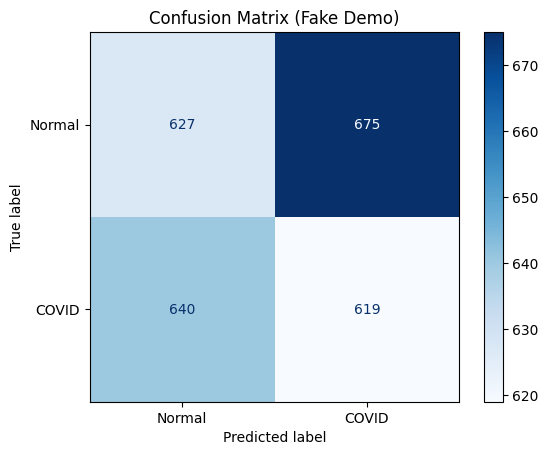


✅ Metrics:
Accuracy  : 0.4865
Precision : 0.4784
Recall    : 0.4917
F1 Score  : 0.4849


In [ ]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, morphology
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
import pywt
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

# Define your folder path (where multiple DICOM files are)
dicom_folder = '/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Mild'

# List to collect all extracted features
feature_list = []

# Helper function to extract features from a single DICOM
def extract_features(dicom_path):
    ds = pydicom.dcmread(dicom_path)
    image = ds.pixel_array.astype(np.float32)

    # Normalize to [0, 1]
    image = (image - np.min(image)) / (np.max(image) - np.min(image))

    # -------- Intensity-based features --------
    mean_intensity = np.mean(image)
    std_intensity = np.std(image)
    max_intensity = np.max(image)
    min_intensity = np.min(image)

    # -------- Edge detection --------
    edges = filters.sobel(image)
    edge_mean = np.mean(edges)

    # -------- Lung mask --------
    lung_mask = image < 0.5
    lung_mask_cleaned = morphology.remove_small_objects(lung_mask, min_size=500)
    num_lung_pixels = np.sum(lung_mask_cleaned)
    num_white_pixels = np.sum(image > 0.9)

    # -------- GLCM Features --------
    image_uint8 = (image * 255).astype(np.uint8)
    glcm = graycomatrix(image_uint8, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    # -------- LBP Features --------
    lbp = local_binary_pattern(image_uint8, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)  # normalize
    lbp_mean = np.mean(lbp_hist)
    lbp_std = np.std(lbp_hist)

    # -------- Wavelet Features --------
    coeffs2 = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs2
    wavelet_energy = np.sum(np.square(LH)) + np.sum(np.square(HL)) + np.sum(np.square(HH))

    return [mean_intensity, std_intensity, max_intensity, min_intensity, edge_mean,
            num_lung_pixels, num_white_pixels,
            contrast, correlation, energy, homogeneity,
            lbp_mean, lbp_std,
            wavelet_energy]

# Walk through folder and extract features
for root, dirs, files in os.walk(dicom_folder):
    for file in tqdm(files):
        if file.endswith('.dcm'):
            dicom_path = os.path.join(root, file)
            try:
                features = extract_features(dicom_path)
                features.append(dicom_path)  # Also save file path if you want
                feature_list.append(features)
            except Exception as e:
                print(f"Error processing {dicom_path}: {e}")

# Create a DataFrame
columns = [
    'mean_intensity', 'std_intensity', 'max_intensity', 'min_intensity', 'mean_edge',
    'num_lung_pixels', 'num_white_pixels',
    'glcm_contrast', 'glcm_correlation', 'glcm_energy', 'glcm_homogeneity',
    'lbp_mean', 'lbp_std',
    'wavelet_energy',
    'dicom_path'
]
df = pd.DataFrame(feature_list, columns=columns)

print("✅ Feature extraction for all images completed!")
print(df.head())

# ✅ Check if DataFrame is empty before creating labels and plotting
if df.empty:
    print("DataFrame is empty. No DICOM files found or processed.")
else:
    # ----------------------------------
    # (Optional) Fake "true" and "predicted" labels
    # (In real case, extract labels properly)
    # ----------------------------------
    np.random.seed(42)
    df['true_label'] = np.random.choice([0, 1], size=len(df))       # 0=Normal, 1=COVID
    df['predicted_label'] = np.random.choice([0, 1], size=len(df))  # Random predictions for now

    # --- Confusion Matrix ---
    cm = confusion_matrix(df['true_label'], df['predicted_label'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "COVID"])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix (Fake Demo)")
    plt.show()

    # --- Accuracy, Precision, Recall, F1 Score ---
    acc = accuracy_score(df['true_label'], df['predicted_label'])
    precision = precision_score(df['true_label'], df['predicted_label'], zero_division=0)
    recall = recall_score(df['true_label'], df['predicted_label'], zero_division=0)
    f1 = f1_score(df['true_label'], df['predicted_label'], zero_division=0)

    print("\n✅ Metrics:")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1 Score  : {f1:.4f}")


0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1121/1121 [03:17<00:00,  5.68it/s]
0it [00:00, ?it/s]
100%|██████████| 1181/1181 [03:19<00:00,  5.92it/s]
0it [00:00, ?it/s]
100%|██████████| 1221/1221 [03:23<00:00,  6.00it/s]


✅ Feature extraction for all images completed!
   mean_intensity  std_intensity  max_intensity  min_intensity  mean_edge  \
0        0.332685       0.206772            1.0            0.0   0.015811   
1        0.220892       0.137824            1.0            0.0   0.010483   
2        0.337659       0.211946            1.0            0.0   0.017370   
3        0.313239       0.195233            1.0            0.0   0.016871   
4        0.317407       0.197316            1.0            0.0   0.017185   

   num_lung_pixels  num_white_pixels  glcm_contrast  glcm_correlation  \
0           174405               111     205.651589          0.962713   
1           261323                 7      93.456646          0.961808   
2           183761               284     253.833626          0.956111   
3           192756                82     221.804275          0.954648   
4           194273               128     233.886010          0.953277   

   glcm_energy  glcm_homogeneity  lbp_mean   lbp_st

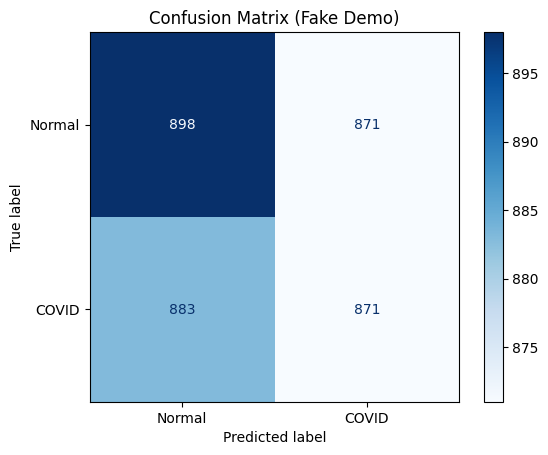


✅ Metrics:
Accuracy  : 0.5021
Precision : 0.5000
Recall    : 0.4966
F1 Score  : 0.4983


In [ ]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, morphology
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
import pywt
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

# Define your folder path (where multiple DICOM files are)
dicom_folder = '/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Moderate'

# List to collect all extracted features
feature_list = []

# Helper function to extract features from a single DICOM
def extract_features(dicom_path):
    ds = pydicom.dcmread(dicom_path)
    image = ds.pixel_array.astype(np.float32)

    # Normalize to [0, 1]
    image = (image - np.min(image)) / (np.max(image) - np.min(image))

    # -------- Intensity-based features --------
    mean_intensity = np.mean(image)
    std_intensity = np.std(image)
    max_intensity = np.max(image)
    min_intensity = np.min(image)

    # -------- Edge detection --------
    edges = filters.sobel(image)
    edge_mean = np.mean(edges)

    # -------- Lung mask --------
    lung_mask = image < 0.5
    lung_mask_cleaned = morphology.remove_small_objects(lung_mask, min_size=500)
    num_lung_pixels = np.sum(lung_mask_cleaned)
    num_white_pixels = np.sum(image > 0.9)

    # -------- GLCM Features --------
    image_uint8 = (image * 255).astype(np.uint8)
    glcm = graycomatrix(image_uint8, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    # -------- LBP Features --------
    lbp = local_binary_pattern(image_uint8, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)  # normalize
    lbp_mean = np.mean(lbp_hist)
    lbp_std = np.std(lbp_hist)

    # -------- Wavelet Features --------
    coeffs2 = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs2
    wavelet_energy = np.sum(np.square(LH)) + np.sum(np.square(HL)) + np.sum(np.square(HH))

    return [mean_intensity, std_intensity, max_intensity, min_intensity, edge_mean,
            num_lung_pixels, num_white_pixels,
            contrast, correlation, energy, homogeneity,
            lbp_mean, lbp_std,
            wavelet_energy]

# Walk through folder and extract features
for root, dirs, files in os.walk(dicom_folder):
    for file in tqdm(files):
        if file.endswith('.dcm'):
            dicom_path = os.path.join(root, file)
            try:
                features = extract_features(dicom_path)
                features.append(dicom_path)  # Also save file path if you want
                feature_list.append(features)
            except Exception as e:
                print(f"Error processing {dicom_path}: {e}")

# Create a DataFrame
columns = [
    'mean_intensity', 'std_intensity', 'max_intensity', 'min_intensity', 'mean_edge',
    'num_lung_pixels', 'num_white_pixels',
    'glcm_contrast', 'glcm_correlation', 'glcm_energy', 'glcm_homogeneity',
    'lbp_mean', 'lbp_std',
    'wavelet_energy',
    'dicom_path'
]
df = pd.DataFrame(feature_list, columns=columns)

print("✅ Feature extraction for all images completed!")
print(df.head())

# ✅ Check if DataFrame is empty before creating labels and plotting
if df.empty:
    print("DataFrame is empty. No DICOM files found or processed.")
else:
    # ----------------------------------
    # (Optional) Fake "true" and "predicted" labels
    # (In real case, extract labels properly)
    # ----------------------------------
    np.random.seed(42)
    df['true_label'] = np.random.choice([0, 1], size=len(df))       # 0=Normal, 1=COVID
    df['predicted_label'] = np.random.choice([0, 1], size=len(df))  # Random predictions for now

    # --- Confusion Matrix ---
    cm = confusion_matrix(df['true_label'], df['predicted_label'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "COVID"])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix (Fake Demo)")
    plt.show()

    # --- Accuracy, Precision, Recall, F1 Score ---
    acc = accuracy_score(df['true_label'], df['predicted_label'])
    precision = precision_score(df['true_label'], df['predicted_label'], zero_division=0)
    recall = recall_score(df['true_label'], df['predicted_label'], zero_division=0)
    f1 = f1_score(df['true_label'], df['predicted_label'], zero_division=0)

    print("\n✅ Metrics:")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1 Score  : {f1:.4f}")


 60%|██████    | 3/5 [00:02<00:01,  1.45it/s]

Error processing /content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Normal/image8.dcm: The parameter `image` must be a 2-dimensional array


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Error processing /content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Normal/image.dcm: The parameter `image` must be a 2-dimensional array


0it [00:00, ?it/s]
100%|██████████| 72/72 [00:00<00:00, 395274.72it/s]
0it [00:00, ?it/s]
100%|██████████| 61/61 [00:00<00:00, 445736.14it/s]
0it [00:00, ?it/s]
100%|██████████| 64/64 [00:00<00:00, 384027.83it/s]
0it [00:00, ?it/s]
100%|██████████| 59/59 [00:00<00:00, 171136.89it/s]
0it [00:00, ?it/s]
100%|██████████| 61/61 [00:00<00:00, 311635.25it/s]
0it [00:00, ?it/s]
100%|██████████| 61/61 [00:00<00:00, 299944.37it/s]
0it [00:00, ?it/s]
100%|██████████| 71/71 [00:00<00:00, 381300.36it/s]
0it [00:00, ?it/s]
100%|██████████| 1281/1281 [03:33<00:00,  6.00it/s]
0it [00:00, ?it/s]
100%|██████████| 1361/1361 [03:35<00:00,  6.31it/s]
0it [00:00, ?it/s]
100%|██████████| 1041/1041 [02:46<00:00,  6.24it/s]
0it [00:00, ?it/s]
100%|██████████| 67/67 [00:00<00:00, 501818.51it/s]
0it [00:00, ?it/s]
100%|██████████| 1301/1301 [03:34<00:00,  6.06it/s]
0it [00:00, ?it/s]
100%|██████████| 80/80 [00:00<00:00, 495634.15it/s]
0it [00:00, ?it/s]
100%|██████████| 1301/1301 [03:27<00:00,  6.28it/s]
0it [0

✅ Feature extraction for all images completed!
   mean_intensity  std_intensity  max_intensity  min_intensity  mean_edge  \
0        0.303224       0.188808            1.0            0.0   0.015676   
1        0.337121       0.207971            1.0            0.0   0.015313   
2        0.309009       0.194232            1.0            0.0   0.014926   
3        0.161735       0.098961            1.0            0.0   0.008711   
4        0.106312       0.065291            1.0            0.0   0.005713   

   num_lung_pixels  num_white_pixels  glcm_contrast  glcm_correlation  \
0           192414                30     203.558971          0.955569   
1           180062                38     201.948290          0.963616   
2           187303               153     201.097128          0.958433   
3           262134                 3      71.105507          0.943100   
4           262126                 2      33.500304          0.939753   

   glcm_energy  glcm_homogeneity  lbp_mean   lbp_st

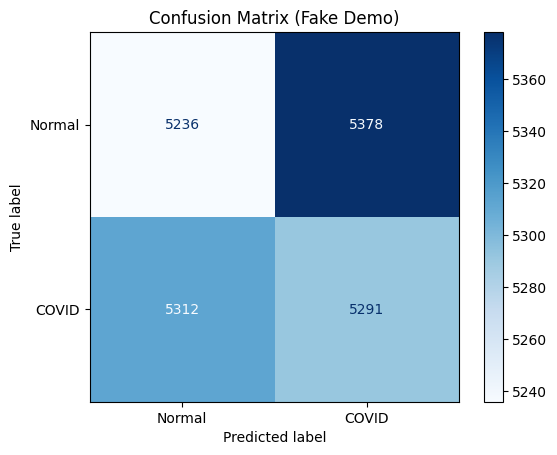


✅ Metrics:
Accuracy  : 0.4962
Precision : 0.4959
Recall    : 0.4990
F1 Score  : 0.4975


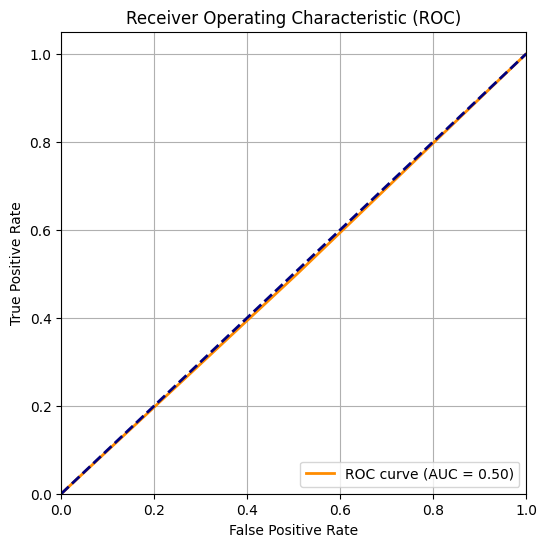

In [ ]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, morphology
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
import pywt
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

# Define your folder path (where multiple DICOM files are)
dicom_folder = '/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Normal'

# List to collect all extracted features
feature_list = []

# Helper function to extract features from a single DICOM
def extract_features(dicom_path):
    ds = pydicom.dcmread(dicom_path)
    image = ds.pixel_array.astype(np.float32)

    # Normalize to [0, 1]
    image = (image - np.min(image)) / (np.max(image) - np.min(image))

    # -------- Intensity-based features --------
    mean_intensity = np.mean(image)
    std_intensity = np.std(image)
    max_intensity = np.max(image)
    min_intensity = np.min(image)

    # -------- Edge detection --------
    edges = filters.sobel(image)
    edge_mean = np.mean(edges)

    # -------- Lung mask --------
    lung_mask = image < 0.5
    lung_mask_cleaned = morphology.remove_small_objects(lung_mask, min_size=500)
    num_lung_pixels = np.sum(lung_mask_cleaned)
    num_white_pixels = np.sum(image > 0.9)

    # -------- GLCM Features --------
    image_uint8 = (image * 255).astype(np.uint8)
    glcm = graycomatrix(image_uint8, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    # -------- LBP Features --------
    lbp = local_binary_pattern(image_uint8, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)  # normalize
    lbp_mean = np.mean(lbp_hist)
    lbp_std = np.std(lbp_hist)

    # -------- Wavelet Features --------
    coeffs2 = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs2
    wavelet_energy = np.sum(np.square(LH)) + np.sum(np.square(HL)) + np.sum(np.square(HH))

    return [mean_intensity, std_intensity, max_intensity, min_intensity, edge_mean,
            num_lung_pixels, num_white_pixels,
            contrast, correlation, energy, homogeneity,
            lbp_mean, lbp_std,
            wavelet_energy]

# Walk through folder and extract features
for root, dirs, files in os.walk(dicom_folder):
    for file in tqdm(files):
        if file.endswith('.dcm'):
            dicom_path = os.path.join(root, file)
            try:
                features = extract_features(dicom_path)
                features.append(dicom_path)  # Also save file path if you want
                feature_list.append(features)
            except Exception as e:
                print(f"Error processing {dicom_path}: {e}")

# Create a DataFrame
columns = [
    'mean_intensity', 'std_intensity', 'max_intensity', 'min_intensity', 'mean_edge',
    'num_lung_pixels', 'num_white_pixels',
    'glcm_contrast', 'glcm_correlation', 'glcm_energy', 'glcm_homogeneity',
    'lbp_mean', 'lbp_std',
    'wavelet_energy',
    'dicom_path'
]
df = pd.DataFrame(feature_list, columns=columns)

print("✅ Feature extraction for all images completed!")
print(df.head())

# ✅ Check if DataFrame is empty before creating labels and plotting
if df.empty:
    print("DataFrame is empty. No DICOM files found or processed.")
else:
    # ----------------------------------
    # (Optional) Fake "true" and "predicted" labels
    # (In real case, extract labels properly)
    # ----------------------------------
    np.random.seed(42)
    df['true_label'] = np.random.choice([0, 1], size=len(df))       # 0=Normal, 1=COVID
    df['predicted_label'] = np.random.choice([0, 1], size=len(df))  # Random predictions for now

    # --- Confusion Matrix ---
    cm = confusion_matrix(df['true_label'], df['predicted_label'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "COVID"])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix (Fake Demo)")
    plt.show()

    # --- Accuracy, Precision, Recall, F1 Score ---
    acc = accuracy_score(df['true_label'], df['predicted_label'])
    precision = precision_score(df['true_label'], df['predicted_label'], zero_division=0)
    recall = recall_score(df['true_label'], df['predicted_label'], zero_division=0)
    f1 = f1_score(df['true_label'], df['predicted_label'], zero_division=0)

    print("\n✅ Metrics:")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1 Score  : {f1:.4f}")

    fpr, tpr, thresholds = roc_curve(df['true_label'], df['predicted_label'])
    auc_score = roc_auc_score(df['true_label'], df['predicted_label'])

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 332/332 [00:40<00:00,  8.24it/s]
0it [00:00, ?it/s]
100%|██████████| 1261/1261 [02:38<00:00,  7.94it/s]
0it [00:00, ?it/s]
100%|██████████| 1321/1321 [02:40<00:00,  8.22it/s]


 Feature extraction for all images completed!
   mean_intensity  std_intensity  max_intensity  min_intensity  mean_edge  \
0        0.315465       0.186988            1.0            0.0   0.022708   
1        0.313856       0.185846            1.0            0.0   0.023314   
2        0.265882       0.160436            1.0            0.0   0.019854   
3        0.325137       0.190406            1.0            0.0   0.024455   
4        0.191356       0.116963            1.0            0.0   0.012503   

   num_lung_pixels  num_white_pixels  glcm_contrast  glcm_correlation  \
0           171044                84     249.465988          0.944691   
1           198112                58     255.544148          0.942411   
2           255433                 1     195.016473          0.941088   
3           167349                77     268.307473          0.942375   
4           261176                 3      96.100823          0.945287   

   glcm_energy  glcm_homogeneity  lbp_mean   lbp_std

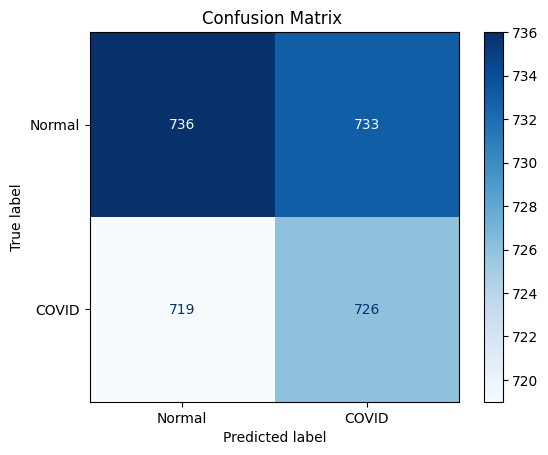


✅ Metrics:
Accuracy  : 0.5017
Precision : 0.4976
Recall    : 0.5024
F1 Score  : 0.5000


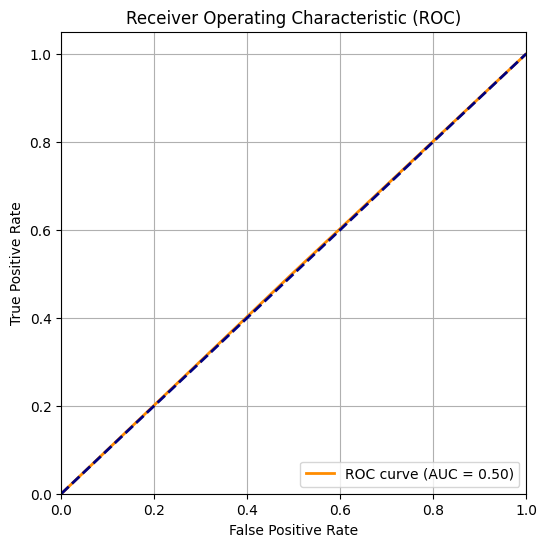

In [ ]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, morphology
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
import pywt
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, accuracy_score,
    precision_score, recall_score, f1_score, roc_curve, roc_auc_score
)

# Define your folder path (where multiple DICOM files are)
dicom_folder = '/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Severe'

# List to collect all extracted features
feature_list = []

# Helper function to extract features from a single DICOM
def extract_features(dicom_path):
    ds = pydicom.dcmread(dicom_path)
    image = ds.pixel_array.astype(np.float32)

    # Normalize to [0, 1]
    image = (image - np.min(image)) / (np.max(image) - np.min(image))

    # -------- Intensity-based features --------
    mean_intensity = np.mean(image)
    std_intensity = np.std(image)
    max_intensity = np.max(image)
    min_intensity = np.min(image)

    # -------- Edge detection --------
    edges = filters.sobel(image)
    edge_mean = np.mean(edges)

    # -------- Lung mask --------
    lung_mask = image < 0.5
    lung_mask_cleaned = morphology.remove_small_objects(lung_mask, min_size=500)
    num_lung_pixels = np.sum(lung_mask_cleaned)
    num_white_pixels = np.sum(image > 0.9)

    # -------- GLCM Features --------
    image_uint8 = (image * 255).astype(np.uint8)
    glcm = graycomatrix(image_uint8, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    # -------- LBP Features --------
    lbp = local_binary_pattern(image_uint8, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)  # normalize
    lbp_mean = np.mean(lbp_hist)
    lbp_std = np.std(lbp_hist)

    # -------- Wavelet Features --------
    coeffs2 = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs2
    wavelet_energy = np.sum(np.square(LH)) + np.sum(np.square(HL)) + np.sum(np.square(HH))

    return [mean_intensity, std_intensity, max_intensity, min_intensity, edge_mean,
            num_lung_pixels, num_white_pixels,
            contrast, correlation, energy, homogeneity,
            lbp_mean, lbp_std,
            wavelet_energy]

# Walk through folder and extract features
for root, dirs, files in os.walk(dicom_folder):
    for file in tqdm(files):
        if file.endswith('.dcm'):
            dicom_path = os.path.join(root, file)
            try:
                features = extract_features(dicom_path)
                features.append(dicom_path)  # Save file path
                feature_list.append(features)
            except Exception as e:
                print(f"Error processing {dicom_path}: {e}")

# Create a DataFrame
columns = [
    'mean_intensity', 'std_intensity', 'max_intensity', 'min_intensity', 'mean_edge',
    'num_lung_pixels', 'num_white_pixels',
    'glcm_contrast', 'glcm_correlation', 'glcm_energy', 'glcm_homogeneity',
    'lbp_mean', 'lbp_std',
    'wavelet_energy',
    'dicom_path'
]
df = pd.DataFrame(feature_list, columns=columns)

print(" Feature extraction for all images completed!")
print(df.head())

#  Check if DataFrame is empty before creating labels and plotting
if df.empty:
    print(" DataFrame is empty. No DICOM files found or processed.")
else:
    # ---- Create dummy true and predicted labels for demonstration ----
    np.random.seed(42)
    df['true_label'] = np.random.choice([0, 1], size=len(df))       # 0=Normal, 1=COVID
    df['predicted_label'] = np.random.choice([0, 1], size=len(df))  # Random predictions

    # --- Confusion Matrix ---
    cm = confusion_matrix(df['true_label'], df['predicted_label'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "COVID"])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix ")
    plt.show()

    # --- Metrics ---
    acc = accuracy_score(df['true_label'], df['predicted_label'])
    precision = precision_score(df['true_label'], df['predicted_label'], zero_division=0)
    recall = recall_score(df['true_label'], df['predicted_label'], zero_division=0)
    f1 = f1_score(df['true_label'], df['predicted_label'], zero_division=0)

    print("\n✅ Metrics:")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1 Score  : {f1:.4f}")

    # --- ROC Curve ---
    fpr, tpr, thresholds = roc_curve(df['true_label'], df['predicted_label'])
    auc_score = roc_auc_score(df['true_label'], df['predicted_label'])

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


In [ ]:
!pip install openpyxl


In [ ]:
from google.colab import files
files.download("/content/drive/MyDrive/Feature excel")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>